# ***Mining Airline Delays for Clusters, Patterns, and Anomalies***
##### *CSCI-S-108 Data Mining Final Project*  
##### *Harvard University Extension School*  
##### *Noah Eilken, Master’s Degree Candidate in Data Science*  

## Purpose

Flight delays are a widespread and costly issue in the U.S. air transportation system, affecting passengers, carriers, and airport operations. Mining patterns in historical flight data can reveal underlying structural inefficiencies, surface regional or route-specific challenges, and inform more resilient scheduling and resource allocation strategies. Unsupervised learning techniques are well-suited for this type of exploratory analysis, enabling the discovery of hidden groupings and outliers without requiring labeled data ideal for large-scale, high-dimensional datasets such as those derived from airline operations.

This project aims to uncover delay patterns across U.S. flight routes using the full 2007 Airline On-Time Performance dataset from the ASA Data Expo. The analysis will apply multiple unsupervised data mining methods, including dimensionality reduction and clustering to explore and interpret latent structure in flight delay behavior.

## Executive Summary

Executive Summary
We analyzed the 2007 ASA Airline On-Time Performance dataset to identify patterns and anomalies in route-level delays. Our goal was to cluster routes by operational characteristics (arrival, departure, and causal delay components, distance, schedule, and volume) to support targeted interventions in scheduling, staffing, and network planning.

We prepared the data by removing cancelled/diverted flights, filtering to active routes, aggregating features at the route level, and scaling for clustering.

Exploratory Data Analysis revealed variation by distance, departure hour, seasonality, carrier, and delay type. We performed PCA to reduce dimensionality for visualization and to assess variance structure, indicating a moderately high-dimensional delay pattern space.

We applied K-Means, Agglomerative, DBSCAN with spectral embeddings, and OPTICS with UMAP, tuning hyperparameters and testing multiple distance metrics. Model performance was evaluated using silhouette scores, Calinski-Harabasz index, and cluster visualization. Spectral embedding with K-Means provided the most interpretable results.

Key findings include:

* Significant regional and carrier differences in delay performance.
* Delay causes vary by cluster, requiring tailored operational strategies.
* Distance and flight volume are not reliable predictors of delay levels.
* Identification of anomalous routes with consistently higher delays.

## Summary of Steps

1. **Preprocessing** – Filter top carriers, remove cancelled/diverted flights, drop irrelevant variables, handle missing data, and derive time-based features.

2. **EDA** – Explore delay distributions, temporal trends, top airports/routes, delay cause proportions, and feature correlations.

3. **Feature Engineering** – Aggregate delay metrics by route, compute averages and variability, normalize features, and construct a graph representation.

4. **Dimensionality Reduction** – Apply PCA and spectral embedding to uncover latent structure and assess variance explained.

5. **Clustering** – Use K-Means, DBSCAN, OPTICS, and Agglomerative clustering with different distances and linkage strategies; tune parameters and evaluate with multiple metrics.

6. **Interpretation** – Analyze cluster profiles by delay causes, region, carrier, and operational characteristics.

7. **Conclusions** – Discuss operational implications, carrier/region performance, and anomaly detection.

8. **Improvements & Future Work** – Propose embedding refinements, temporal analysis, and multi-year stability testing.






## Dataset Summary

This project uses the 2007 U.S. Airline On-Time Performance dataset, originally compiled by the U.S. Department of Transportation and released as part of the ASA Data Expo 2009. It includes detailed flight-level records for all U.S. commercial flights, covering delay information, carrier codes, origin/destination airports, and delay causes.

**Source**: ASA Data Expo 2009 (via Harvard Dataverse)

**Time Frame**: January 1, 2007 – December 31, 2007

**Scope**: Domestic flights within the U.S. and U.S. territories

**Size**: ~7 million flight records

**Format**: Compressed CSV (.csv.bz2)

## Variable Descriptions

| Column Name          | Description |
|----------------------|-------------|
| `Year`               | The year of the flight (e.g., 2007) |
| `Month`              | Month of the flight (1 = January, ..., 12 = December) |
| `DayofMonth`         | Day of the month (1–31) |
| `DayOfWeek`          | Day of the week (1 = Monday, ..., 7 = Sunday) |
| `DepTime`            | Actual departure time (local, HHMM format) |
| `CRSDepTime`         | Scheduled departure time (local, HHMM format) |
| `ArrTime`            | Actual arrival time (local, HHMM format) |
| `CRSArrTime`         | Scheduled arrival time (local, HHMM format) |
| `UniqueCarrier`      | Airline carrier code (e.g., 'AA' for American Airlines) |
| `FlightNum`          | Flight number assigned by the carrier |
| `TailNum`            | Aircraft registration number (tail number) |
| `ActualElapsedTime`  | Actual total flight time (in minutes) |
| `CRSElapsedTime`     | Scheduled total flight time (in minutes) |
| `AirTime`            | Actual time spent in the air (in minutes) |
| `ArrDelay`           | Arrival delay in minutes (early arrivals are negative) |
| `DepDelay`           | Departure delay in minutes (early departures are negative) |
| `Origin`             | Origin airport IATA code (e.g., 'ATL', 'ORD') |
| `Dest`               | Destination airport IATA code |
| `Distance`           | Great-circle distance between origin and destination (in miles) |
| `TaxiIn`             | Time spent taxiing after landing (in minutes) |
| `TaxiOut`            | Time spent taxiing before takeoff (in minutes) |
| `Cancelled`          | 1 = Flight was cancelled, 0 = Not cancelled |
| `CancellationCode`   | Reason for cancellation: A = Carrier, B = Weather, C = NAS, D = Security |
| `Diverted`           | 1 = Flight was diverted to another airport, 0 = Not diverted |
| `CarrierDelay`       | Delay caused by airline operations (in minutes) |
| `WeatherDelay`       | Delay caused by weather conditions |
| `NASDelay`           | Delay caused by National Airspace System (traffic, air traffic control, etc.) |
| `SecurityDelay`      | Delay caused by security issues (e.g., TSA) |
| `LateAircraftDelay`  | Delay caused by a late-arriving aircraft from a previous flight |


## Import Libraries

In [ ]:
#!pip install kneed
#!pip install scikit-posthocs
#!pip install umap-learn

In [ ]:
# ======================================
# Standard Libraries
# ======================================
import os
import requests
from tqdm import tqdm
from itertools import product

# ======================================
# Data Manipulation
# ======================================
import pandas as pd
import numpy as np

# ======================================
# Visualization
# ======================================
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from mpl_toolkits.mplot3d import Axes3D

# ======================================
# Preprocessing
# ======================================
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# ======================================
# Dimensionality Reduction
# ======================================
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE, SpectralEmbedding
import umap

# ======================================
# Clustering Algorithms
# ======================================
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

# ======================================
# Evaluation Metrics
# ======================================
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from kneed import KneeLocator
import scipy.stats as stats
import scikit_posthocs as sp

# ======================================
# Graph-Based Analysis
# ======================================
import networkx as nx
from scipy.sparse import csr_matrix
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
# ======================================
# Google Colab
# ======================================
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the Data

The data was obtained from the Harvard Dataverse and saved in compressed .csv.bz2 format. It was loaded into a Google Colab environment directly from Google Drive.

In [ ]:
# Create data folder in Drive
save_dir = '/content/drive/MyDrive/airline_data'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
# Download each year using its persistent ID (PID)
year_pid_map = {
    #2004: "doi:10.7910/DVN/HG7NV7/CCAZGT",
    #2005: "doi:10.7910/DVN/HG7NV7/JTFT25",
    #2006: "doi:10.7910/DVN/HG7NV7/EPIFFT",
    2007: "doi:10.7910/DVN/HG7NV7/2BHLWK",
    #2008: "doi:10.7910/DVN/HG7NV7/EIR0RA"
}

for year, pid in year_pid_map.items():
    out_path = f"{save_dir}/{year}.csv.bz2"
    if not os.path.exists(out_path):
        print(f"Downloading {year}...")
        url = f"https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId={pid}"
        !wget -O "{out_path}" "{url}"
    else:
        print(f"{year}.csv.bz2 already exists.")

2007.csv.bz2 already exists.


In [ ]:
# Path to the 2007 file
file_2007 = '/content/drive/MyDrive/airline_data/2007.csv.bz2'

# Load and display the first few rows
df_2007 = pd.read_csv(file_2007, low_memory=False)
print(f"2007 Data Loaded — Shape: {df_2007.shape}")
df_2007.head()

2007 Data Loaded — Shape: (7453215, 29)


Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  2007      1           1          1   1232.0        1225   1341.0   
1  2007      1           1          1   1918.0        1905   2043.0   
2  2007      1           1          1   2206.0        2130   2334.0   
3  2007      1           1          1   1230.0        1200   1356.0   
4  2007      1           1          1    831.0         830    957.0   

   CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
0        1340            WN       2891  ...      4       11          0   
1        2035            WN        462  ...      5        6          0   
2        2300            WN       1229  ...      6        9          0   
3        1330            WN       1355  ...      3        8          0   
4        1000            WN       2278  ...      3        9          0   

   CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
0               NaN         0             0            0        0   
1               NaN         0             0            0        0   
2               NaN         0             3            0        0   
3               NaN         0            23            0        0   
4               NaN         0             0            0        0   

   SecurityDelay  LateAircraftDelay  
0              0                  0  
1              0                  0  
2              0                 31  
3              0                  3  
4              0                  0  

[5 rows x 29 columns]

## Preprocessing the Data

In [ ]:
print(f"Total Number of Unique Carriers: {len(df_2007['UniqueCarrier'].unique())}")

Total Number of Unique Carriers: 20


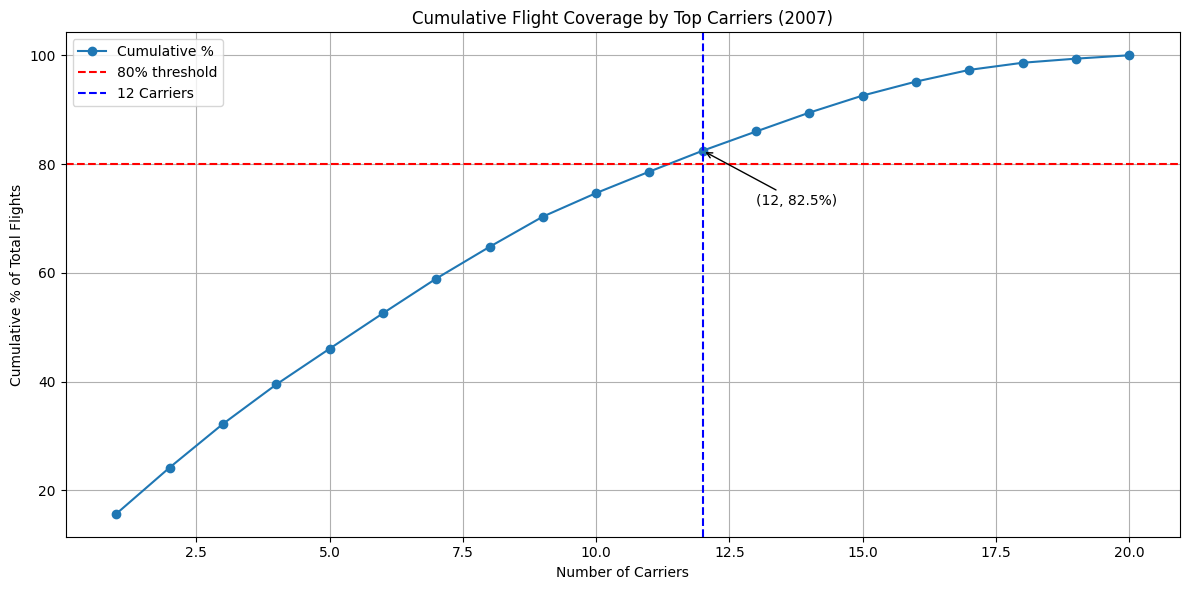

In [ ]:
# Count and sort by number of flights
carrier_counts = df_2007['UniqueCarrier'].value_counts()
cumulative_counts = carrier_counts.cumsum()
total_flights = carrier_counts.sum()
cumulative_percent = cumulative_counts / total_flights * 100

# Find the index (number of carriers) where cumulative percent reaches 80%
min_carriers_80 = (cumulative_percent < 80).sum() + 1
x_val = min_carriers_80
y_val = cumulative_percent.iloc[x_val - 1]

# Plot cumulative percentage
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(carrier_counts)+1), cumulative_percent, marker='o', label='Cumulative %')
plt.axhline(y=80, color='red', linestyle='--', label='80% threshold')
plt.axvline(x=x_val, color='blue', linestyle='--', label=f'{x_val} Carriers')

# Annotate the exact point
plt.annotate(f'({x_val}, {y_val:.1f}%)',
             xy=(x_val, y_val),
             xytext=(x_val + 1, y_val - 10),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Labels and styling
plt.xlabel('Number of Carriers')
plt.ylabel('Cumulative % of Total Flights')
plt.title('Cumulative Flight Coverage by Top Carriers (2007)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

To ensure both representativeness and computational efficiency, we analyzed the cumulative share of total U.S. domestic flights by airline carrier in 2007. As shown in the cumulative coverage graph, the top 12 carriers alone account for over 80% of all flights in the dataset. By selecting these top 12 carriers, we avoid noise from small regional or charter carriers with sparse operations and reduce computational load, but preserve representativeness.

In [ ]:
# Count flights per airline
top_airlines = df_2007['UniqueCarrier'].value_counts().head(12)
print("Top 12 Airlines by Flight Volume in 2007:")
print(top_airlines)

Top 12 Airlines by Flight Volume in 2007:
UniqueCarrier
WN    1168871
AA     633857
OO     597882
MQ     540494
UA     490002
US     485447
DL     475889
XE     434773
NW     414526
CO     323151
YV     294362
EV     286234
Name: count, dtype: int64


### Top 12 Airlines by Flight Volume in 2007
1. WN — Southwest Airlines

2. AA — American Airlines

3. OO — SkyWest Airlines (regional)

4. MQ — Envoy Air (formerly American Eagle, regional)

5. UA — United Airlines

6. US — US Airways

7. DL — Delta Air Lines

8. XE — ExpressJet Airlines (regional)

9. NW — Northwest Airlines

10. CO — Continental Airlines

11. YV — Mesa Airlines (regional)

12. EV — Atlantic Southeast Airlines (regional)

In [ ]:
# Define top 12 airline codes
top_codes = ['WN', 'AA', 'OO', 'MQ', 'UA', 'US', 'DL', 'XE', 'NW', 'CO', 'YV', 'EV']

# Filter the DataFrame
df_top = df_2007[df_2007['UniqueCarrier'].isin(top_codes)].copy()

# Check shape and counts
print(f"Filtered dataset shape: {df_top.shape}")

Filtered dataset shape: (6145488, 29)


We are focusing on delay patterns so we should remove cancelled or diverted flights from our analysis.

In [ ]:
# Remove canceled or diverted flights
df_top = df_top[(df_top['Cancelled'] == 0) & (df_top['Diverted'] == 0)].copy()

print(f"Shape after removing cancelled and diverted flights: {df_top.shape}")

Shape after removing cancelled and diverted flights: (5997383, 29)


We are converting the time Departure time to the hour and adding a column for general time of day (morning, night, etc.)

In [ ]:
# Convert CRSDepTime to hour bins (scheduled dep time)
df_top['CRSDepHour'] = df_top['CRSDepTime'] // 100  # e.g., 1735 -> 17

# Bin into periods of day
df_top['TimeBlock'] = pd.cut(df_top['CRSDepHour'],
                                    bins=[-1, 5, 11, 17, 21, 24],
                                    labels=['Night', 'Morning', 'Afternoon', 'Evening', 'Late Night'])


We are dropping many columns that are not very useful for our analysis

In [ ]:
# Drop columns not very useful for analysis
columns_to_drop = [
    'Year', 'DayofMonth', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime',
    'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime',
    'TaxiIn', 'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted'
]

df_cleaned = df_top.drop(columns=columns_to_drop)

In [ ]:
# Check for nulls in key columns
print(df_cleaned.isnull().sum())
df_cleaned.shape

Month                0
DayOfWeek            0
UniqueCarrier        0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
CRSDepHour           0
TimeBlock            0
dtype: int64


(5997383, 15)

In [ ]:
# Convert columns to categorical
cat_cols = ['UniqueCarrier', 'Origin', 'Dest']
df_cleaned[cat_cols] = df_cleaned[cat_cols].astype('category')
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5997383 entries, 0 to 7453214
Data columns (total 15 columns):
 #   Column             Dtype   
---  ------             -----   
 0   Month              int64   
 1   DayOfWeek          int64   
 2   UniqueCarrier      category
 3   ArrDelay           float64 
 4   DepDelay           float64 
 5   Origin             category
 6   Dest               category
 7   Distance           int64   
 8   CarrierDelay       int64   
 9   WeatherDelay       int64   
 10  NASDelay           int64   
 11  SecurityDelay      int64   
 12  LateAircraftDelay  int64   
 13  CRSDepHour         int64   
 14  TimeBlock          category
dtypes: category(4), float64(2), int64(9)
memory usage: 583.4 MB


In [ ]:
df_cleaned[['ArrDelay', 'DepDelay']].describe()

ArrDelay      DepDelay
count  5.997383e+06  5.997383e+06
mean   1.042089e+01  1.169321e+01
std    3.920850e+01  3.598986e+01
min   -1.750000e+02 -1.650000e+02
25%   -9.000000e+00 -4.000000e+00
50%    0.000000e+00  0.000000e+00
75%    1.500000e+01  1.100000e+01
max    2.598000e+03  2.601000e+03

## Initial Exploratory Data Analysis (EDA)

### Distribution of Delays

The data is skewed right. Most flights are not delayed, many are early, with some flights experiencing significant delays. Outliers will have strong effect.

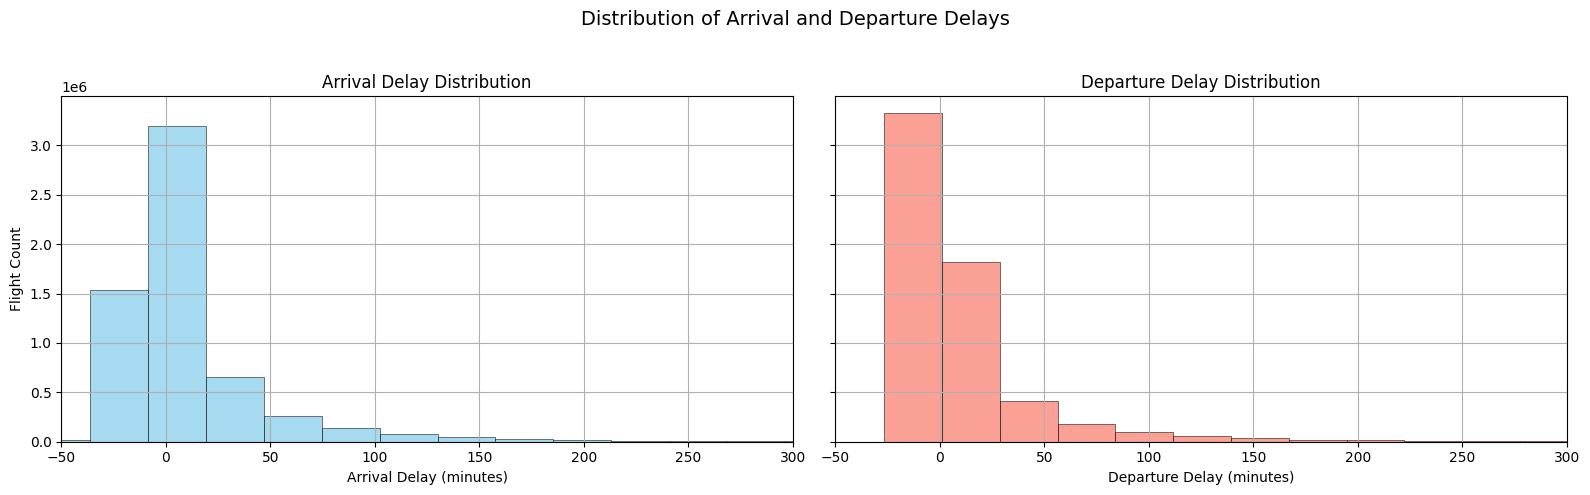

In [ ]:
# Combined histograms: Arrival and Departure Delays
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Arrival Delay
sns.histplot(df_cleaned['ArrDelay'], bins=100, kde=False, color='skyblue', ax=axes[0])
axes[0].set_xlim(-50, 300)
axes[0].set_title('Arrival Delay Distribution')
axes[0].set_xlabel('Arrival Delay (minutes)')
axes[0].set_ylabel('Flight Count')
axes[0].grid(True)

# Departure Delay
sns.histplot(df_cleaned['DepDelay'], bins=100, kde=False, color='salmon', ax=axes[1])
axes[1].set_xlim(-50, 300)
axes[1].set_title('Departure Delay Distribution')
axes[1].set_xlabel('Departure Delay (minutes)')
axes[1].grid(True)

plt.suptitle('Distribution of Arrival and Departure Delays', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Delays by Hour of Day
From 1 AM to 3 AM there is a sharp increase in delays. Then a sharp decrease from 3 AM to 4 AM. From 4 AM to 8 PM the number of delays increases slowly. Then delays decrease from 8 PM to 1 AM.

Patterns vary by hour, making time-related features like CRSDepHour or TimeBlock useful for clustering.

This plot suggests that PCA can capture time-driven variance, and clustering may identify delay-prone hours/routes.

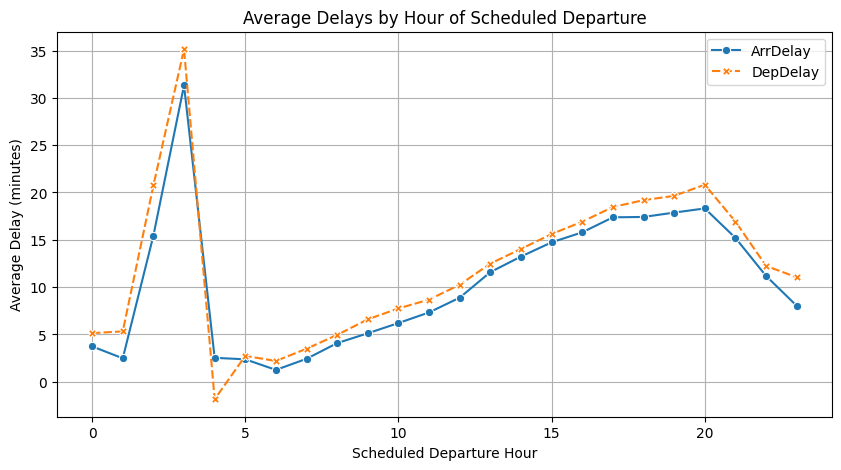

In [ ]:
hourly = df_cleaned.groupby('CRSDepHour')[['ArrDelay', 'DepDelay']].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly, markers=True)
plt.title('Average Delays by Hour of Scheduled Departure')
plt.xlabel('Scheduled Departure Hour')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.show()


### Delays by Day of Week and Month

Friday (Day 5) and Thursday (Day 4) show the highest average delays (~13 minutes).

Saturday (Day 6) has the lowest average delay (~6 minutes).

This suggests weekday traffic leads to greater congestion and cumulative delays, while weekends (especially Saturday) tend to run more smoothly.

June and July show peak delays (~17 and 14 minutes respectively), likely due to summer travel volume and thunderstorm season.

December also shows high delay (~16 minutes), likely due to holiday congestion and winter weather.

September has the lowest delay (~4 minutes), likely reflecting a dip in travel volume post-summer and pre-holiday.

Temporal features like month and day of week play a clear role in delay patterns.

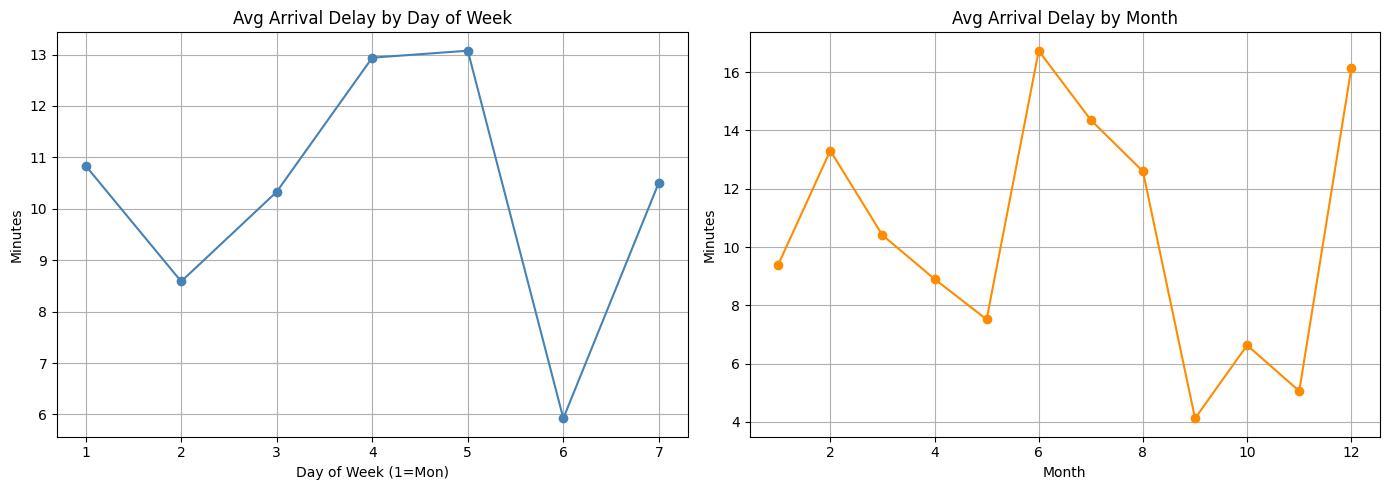

In [ ]:
# Calculate average delays
dow = df_cleaned.groupby('DayOfWeek')['ArrDelay'].mean()
month = df_cleaned.groupby('Month')['ArrDelay'].mean()

# Plot as line plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Line plot for Day of Week
axes[0].plot(dow.index, dow.values, marker='o', linestyle='-', color='steelblue')
axes[0].set_title('Avg Arrival Delay by Day of Week')
axes[0].set_xlabel('Day of Week (1=Mon)')
axes[0].set_ylabel('Minutes')
axes[0].grid(True)

# Line plot for Month
axes[1].plot(month.index, month.values, marker='o', linestyle='-', color='darkorange')
axes[1].set_title('Avg Arrival Delay by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Minutes')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Top Airports by Delay

Plot identifies outlier airports that may form their own clusters in delay-based grouping. We can use DBSCAN, to flag these high-delay nodes as anomalies and K-means, to group airports with similar delay profiles.

/tmp/ipython-input-2726709493.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_delay_by_origin = df_cleaned.groupby('Origin')[['ArrDelay', 'DepDelay']].mean()


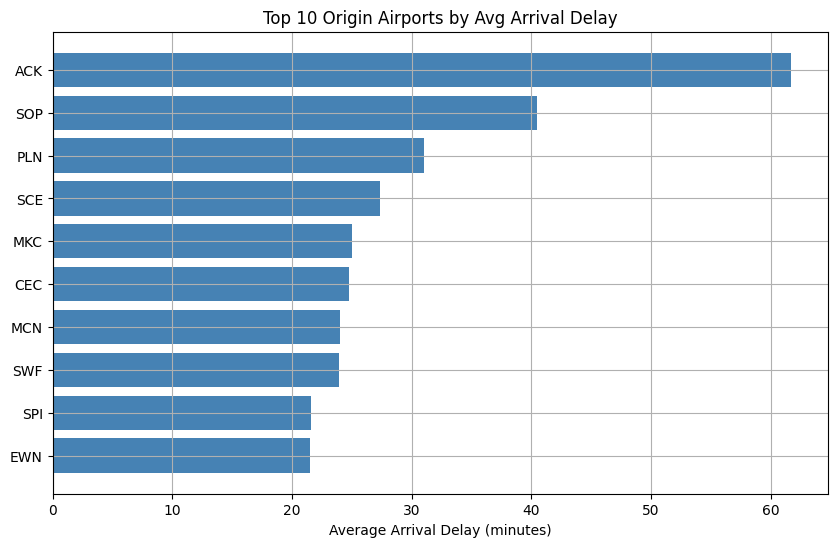

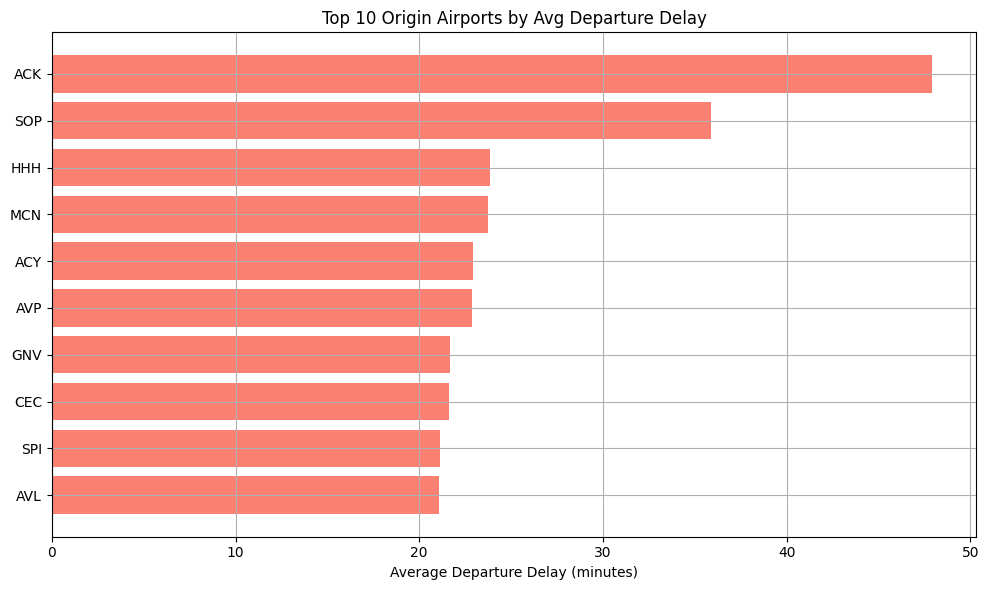

In [ ]:
# Compute average delays by origin airport
avg_delay_by_origin = df_cleaned.groupby('Origin')[['ArrDelay', 'DepDelay']].mean()

# Get top 10 airports by average arrival delay
top10_arr_origins = avg_delay_by_origin['ArrDelay'].sort_values(ascending=False).head(10)
avg_arr_delay_top10 = avg_delay_by_origin.loc[top10_arr_origins.index]

# Get top 10 airports by average departure delay
top10_dep_origins = avg_delay_by_origin['DepDelay'].sort_values(ascending=False).head(10)
avg_dep_delay_top10 = avg_delay_by_origin.loc[top10_dep_origins.index]

# Data for arrival delay plot
arr_airports = avg_arr_delay_top10.index.tolist()
arr_delay_values = avg_arr_delay_top10['ArrDelay'].values
arr_positions = np.arange(len(arr_airports))

# Data for departure delay plot
dep_airports = avg_dep_delay_top10.index.tolist()
dep_delay_values = avg_dep_delay_top10['DepDelay'].values
dep_positions = np.arange(len(dep_airports))

# Plot: Top 10 by arrival delay
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.barh(arr_positions, arr_delay_values, color='steelblue')
ax1.set_yticks(arr_positions)
ax1.set_yticklabels(arr_airports)
ax1.invert_yaxis()
ax1.set_xlabel('Average Arrival Delay (minutes)')
ax1.set_title('Top 10 Origin Airports by Avg Arrival Delay')
ax1.grid(True)

# Plot: Top 10 by departure delay
fig2, ax2 = plt.subplots(figsize=(10, 6))
ax2.barh(dep_positions, dep_delay_values, color='salmon')
ax2.set_yticks(dep_positions)
ax2.set_yticklabels(dep_airports)
ax2.invert_yaxis()
ax2.set_xlabel('Average Departure Delay (minutes)')
ax2.set_title('Top 10 Origin Airports by Avg Departure Delay')
ax2.grid(True)

plt.tight_layout()
plt.show()



The EDA confirms substantial variability and structure in the airline delay dataset, validating the use of dimensionality reduction and clustering methods such as PCA, k-means, and DBSCAN. These findings confirm that the dataset contains rich, structured patterns suitable for unsupervised learning methods aimed at discovering latent delay profiles and identifying anomalous routes or airports.

## Feature Engineering: Route-level Association Matrix using (carrier, origin, destination)

In [ ]:
# Group by (carrier, origin, destination) to compute base features
df_route = df_cleaned.groupby(['UniqueCarrier', 'Origin', 'Dest'], observed=True).agg({
    'ArrDelay': 'mean',
    'DepDelay': 'mean',
    'CarrierDelay': 'mean',
    'WeatherDelay': 'mean',
    'NASDelay': 'mean',
    'SecurityDelay': 'mean',
    'LateAircraftDelay': 'mean',
    'Distance': 'mean',
    'CRSDepHour': 'mean',
    'Month': 'nunique'  # number of months the route is active
}).rename(columns={'Month': 'ActiveMonths'}).reset_index()

# Add flight volume (total flights per route)
df_route['FlightVolume'] = df_cleaned.groupby(['UniqueCarrier', 'Origin', 'Dest'], observed=True).size().values

# Examine df_route
df_route.head()

UniqueCarrier Origin Dest   ArrDelay   DepDelay  CarrierDelay  WeatherDelay  \
0            AA    ABQ  DFW   9.979159   8.644628      3.252605      0.580668   
1            AA    ABQ  ORD  13.853333  12.443333      3.591667      0.635000   
2            AA    ANC  DFW  26.586667  28.100000      8.873333      0.000000   
3            AA    ATL  DFW  11.999730  14.132361      3.624257      1.214209   
4            AA    ATL  LGA  21.285246  18.265574      2.026230      0.386066   

    NASDelay  SecurityDelay  LateAircraftDelay  Distance  CRSDepHour  \
0   3.652533            0.0           5.079770     569.0   11.138699   
1   9.658333            0.0           2.833333    1118.0   10.058333   
2   2.900000            0.0          17.693333    3043.0   22.000000   
3   3.821988            0.0           7.123987     732.0   12.640465   
4  13.521311            0.0           8.520492     761.0   11.997541   

   ActiveMonths  FlightVolume  
0            12          2783  
1            12           600  
2             5           150  
3            12          3702  
4            12          1220

#### Standardize the data for embedding

In [ ]:
# Save labels for plotting or reference
route_labels = df_route[['UniqueCarrier', 'Origin', 'Dest']]

# Prepare data matrix by dropping identifier columns
X_route_features = df_route.drop(columns=['UniqueCarrier', 'Origin', 'Dest'])

# Apply standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_route_features)

# Final result
print("Final feature matrix shape:", X_scaled.shape)
print("Feature columns used:", X_route_features.columns.tolist())


Final feature matrix shape: (6208, 11)
Feature columns used: ['ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Distance', 'CRSDepHour', 'ActiveMonths', 'FlightVolume']


## PCA Exploration (additional EDA)

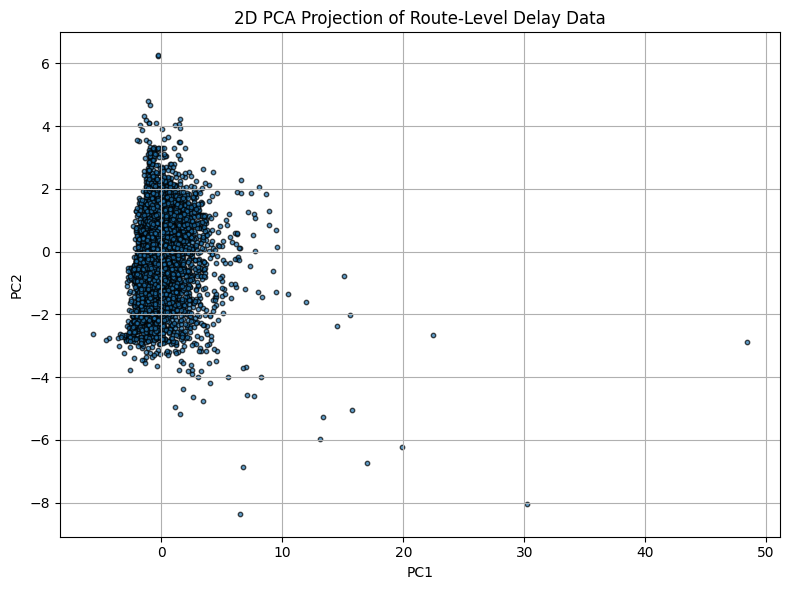

In [ ]:
# Fit PCA with all components
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)

# Cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# 2D PCA visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_full[:, 0], X_pca_full[:, 1], s=10, alpha=0.7, edgecolor='k')
plt.title("2D PCA Projection of Route-Level Delay Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

The PCA projection shows that most variance is along the first principal component, suggesting one dominant pattern drives much of the variation. Most routes cluster tightly near the origin, while a few distant points indicate global outliers with unusual delays. Although PCA does not reveal clear clusters, it highlights the dense core and extreme cases, suggesting that non-linear methods like UMAP or t-SNE, combined with density-based clustering, may better capture the dataset’s structure.

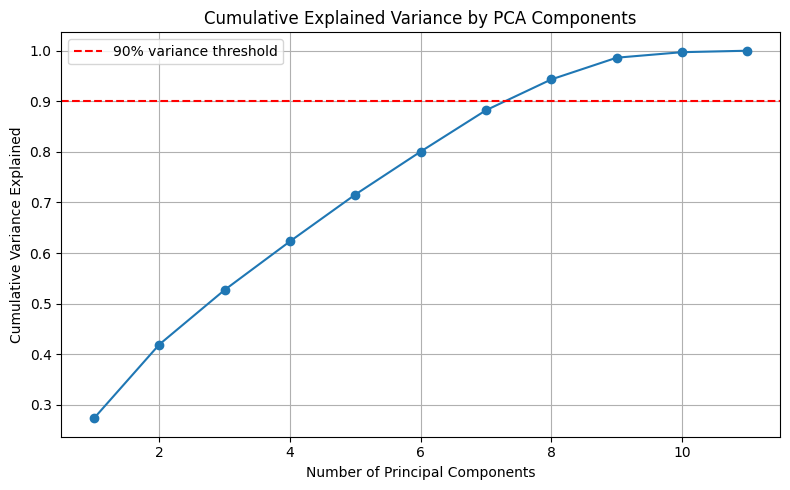

Explained variance: PC1 = 27.31%, PC2 = 14.60%
Total variance explained with 2 PCs: 41.91%
Total variance explained with 8 PCs: 94.33%


In [ ]:
# Fit PCA with all components
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)

# Plot cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.90, color='red', linestyle='--', label='90% variance threshold')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Variance explained with 2 components
explained_var = pca.explained_variance_ratio_
print(f"Explained variance: PC1 = {explained_var[0]:.2%}, PC2 = {explained_var[1]:.2%}")
print(f"Total variance explained with 2 PCs: {np.sum(explained_var[0] + explained_var[1]):.2%}")
print(f"Total variance explained with 8 PCs: {np.sum(explained_var[:8]):.2%}")

PCA is a linear dimensionality reduction method, which means it can only capture linear relationships between features. In this dataset, the variance is spread across many components and not concentrated in the first few, suggesting the underlying structure is likely nonlinear. Because of both the poor variance capture in 2D (only 41.91%) and its inability to model nonlinear patterns, PCA is not a good fit for uncovering meaningful structure in this data. For this reason we considered nonlinear methods.

## Spectral Embedding

#### Why use Spectral Embedding?
Spectral Embedding is based on graph theory and uses the eigenvectors of the graph Laplacian to embed data in a way that preserves local connectivity. This makes it good for datasets where observations are naturally represented as nodes and edges, such as flight routes. Other nonlinear methods like t-SNE or UMAP, rely on manifold learning. Although these methods can be used and may be effective, this project will primarily use Spectral Embedding. Spectral Embedding models the data as a similarity graph, making it better for detecting clusters and community structure in graph-based data. For this reason Spectral Embedding is used.

#### Determining Spectral Embedding Parameters
To select n_components, we computed the Laplacian eigenvalues of the similarity graph and examined the gaps between them. A large gap indicates a natural break in the data's structure, so we selected the number of components based on the first significant eigenvalue gap beyond the trivial zero, capturing the intrinsic dimensionality of the graph. In this case, 2-3 components seems ideal. We tested different values for n_neighbors to find a balance between local and global structure.

Eigenvalue Gaps: [1.37886194 0.148987   0.16321183 0.01935175 0.12761064 0.08441053
 0.03358151 0.03729191 0.02179807 0.01418285 0.03875196 0.06240098
 0.00819344 0.00824325 0.0034887  0.04526607 0.00598459 0.01248324
 0.01896462]


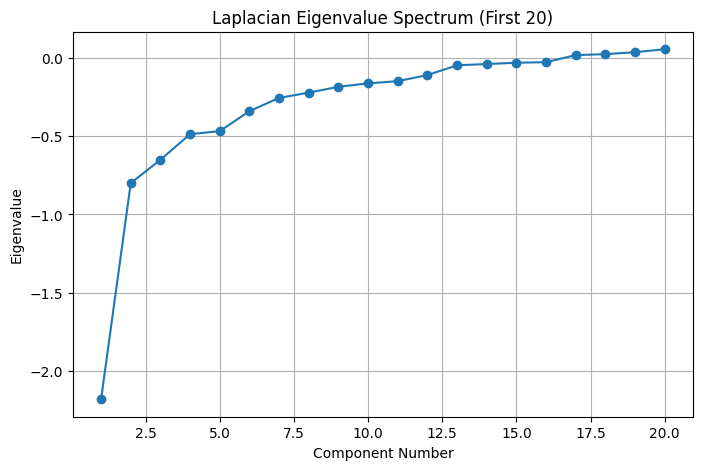

In [ ]:
# Build similarity graph (same as SpectralEmbedding does internally)
knn_graph = kneighbors_graph(X_scaled, n_neighbors=80, include_self=True)
laplacian = csgraph.laplacian(knn_graph, normed=True)

# Compute eigenvalues
eigenvalues, _ = np.linalg.eigh(laplacian.toarray())

# Compute gaps between eigenvalues
eigen_gaps = np.diff(eigenvalues[:20])
optimal_k = np.argmax(eigen_gaps[:])

print("Eigenvalue Gaps:", eigen_gaps)

# Plot scree plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, 21), eigenvalues[:20], marker='o')
plt.title("Laplacian Eigenvalue Spectrum (First 20)")
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()


#### Building the Spectral Embedding

We used Euclidean distance in spectral embedding and clustering to ensure consistency, simplicity, and geometric interpretability. Since the features were numeric and standardized, Euclidean distance provided a meaningful measure of dissimilarity that captured both the magnitude and structure of route-level delays. This choice aligned well with clustering algorithms like KMeans and Agglomerative Clustering and supported our goal of identifying operationally distinct route patterns.

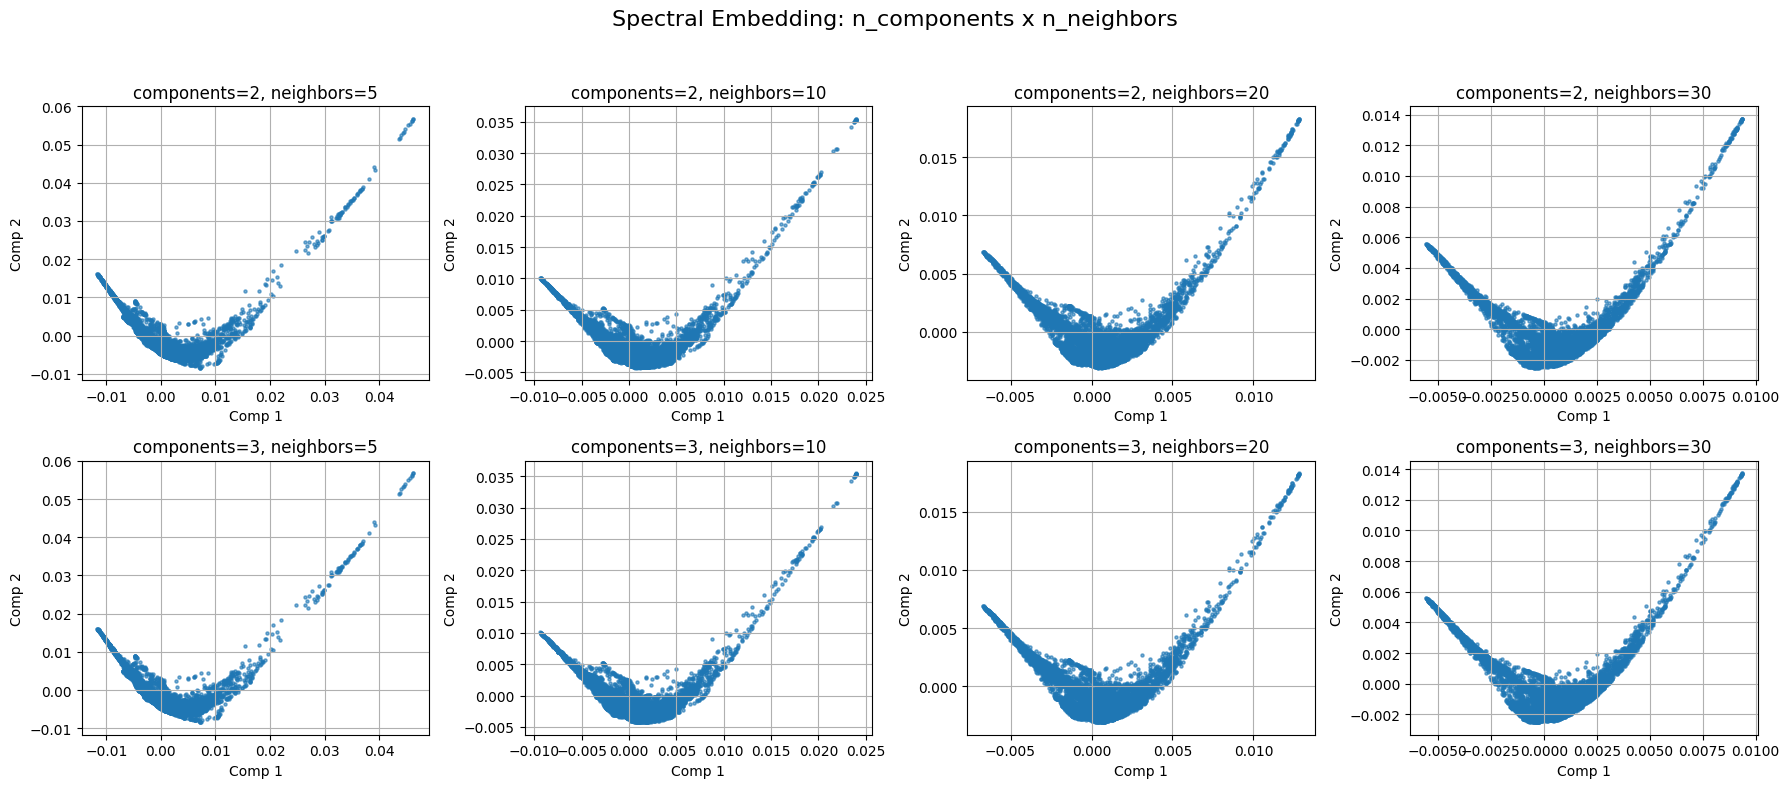

In [ ]:
# Parameters to test
n_components_list = [2, 3]
n_neighbors_list = [5, 10, 20, 30]

# Setup subplot grid
fig, axes = plt.subplots(len(n_components_list), len(n_neighbors_list), figsize=(18, 8))
fig.suptitle("Spectral Embedding: n_components x n_neighbors", fontsize=16)

# Grid search loop
for i, n_components in enumerate(n_components_list):
    for j, n_neighbors in enumerate(n_neighbors_list):
        try:
            # Fit spectral embedding
            spectral = SpectralEmbedding(
                n_components=n_components,
                n_neighbors=n_neighbors,
                affinity='nearest_neighbors',
                random_state=42
            )
            X_embedded = spectral.fit_transform(X_scaled)

            # Select axes
            ax = axes[i][j] if len(n_components_list) > 1 else axes[j]

            # Plot only 2D view
            ax.scatter(X_embedded[:, 0], X_embedded[:, 1], s=5, alpha=0.6)
            ax.set_title(f"components={n_components}, neighbors={n_neighbors}")
            ax.set_xlabel("Comp 1")
            ax.set_ylabel("Comp 2")
            ax.grid(True)

        except Exception as e:
            ax.set_title(f"Failed: c={n_components}, k={n_neighbors}")
            ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The overall curved manifold shape remains consistent across all subplots. This suggests that the underlying structure of the data in the embedded space is robust to these parameter changes.

This stability means Spectral Embedding is capturing the same dominant low-dimensional geometry regardless of moderate changes in parameters.

We will use lower n_neighbors when trying to preserve more local structures, and higher n_neighbors when focusing on global structure.

## **Clustering**

### K-means
Euclidean distance is appropriate for spectral embedding because the embedding maps data into a continuous Euclidean space where distances reflect graph-based similarities. The coordinates are real-valued, making Euclidean distance a valid and meaningful measure for clustering.

Our goal is to focus more on global structure, so we will use higher n_neighbors and n_components.

In [ ]:
# Spectral Embedding
n_components = 3
spectral = SpectralEmbedding(n_components=n_components, affinity='nearest_neighbors', n_neighbors=30, random_state=42)
X_embedded = spectral.fit_transform(X_scaled)

#### Determining K value for K-means by silhouette and CH scores

The graph below shows that silhouette score peaks at k=5 and CH score plateaus at k=5. Generally, the higher these scores are the better the clustering, which is why we chose k=5 for k-means clustering.



k = 2, silhouette score = 0.4190, CH index = 2217.05
k = 3, silhouette score = 0.4266, CH index = 2899.66
k = 4, silhouette score = 0.4493, CH index = 4616.37
k = 5, silhouette score = 0.4581, CH index = 4944.50
k = 6, silhouette score = 0.4101, CH index = 5367.82
k = 7, silhouette score = 0.4147, CH index = 5717.76
k = 8, silhouette score = 0.3712, CH index = 5739.80
k = 9, silhouette score = 0.3849, CH index = 5831.56
k = 10, silhouette score = 0.3866, CH index = 5995.93
k = 11, silhouette score = 0.3730, CH index = 6181.28
k = 12, silhouette score = 0.3639, CH index = 6162.67
k = 13, silhouette score = 0.3654, CH index = 6187.99
k = 14, silhouette score = 0.3647, CH index = 6187.05
k = 15, silhouette score = 0.3644, CH index = 6190.78


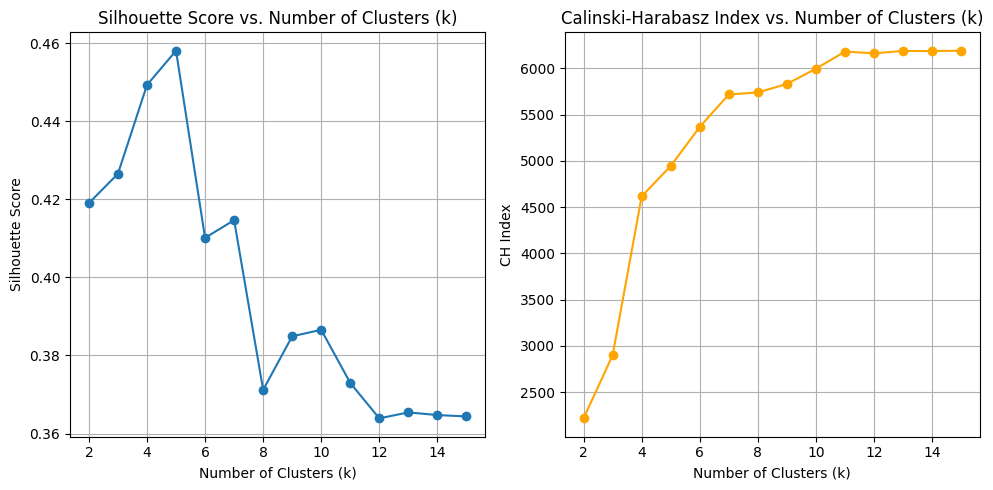

In [ ]:
# Try a range of k values for K-Means
k_range = range(2, 16)
silhouette_scores = []
ch_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_embedded)

    sil_score = silhouette_score(X_embedded, labels)
    ch_score = calinski_harabasz_score(X_embedded, labels)

    silhouette_scores.append(sil_score)
    ch_scores.append(ch_score)

    print(f"k = {k}, silhouette score = {sil_score:.4f}, CH index = {ch_score:.2f}")

# Plot both metrics
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, ch_scores, marker='o', color='orange')
plt.title("Calinski-Harabasz Index vs. Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("CH Index")
plt.grid(True)

plt.tight_layout()
plt.show()


#### K-means clustering with k=5


In [ ]:
# K-Means clustering with k = 5
k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
route_cluster_labels = kmeans.fit_predict(X_embedded)

#### Silhouette and CH Scores
Quantitatively, the clustering achieved a Silhouette Score of 0.4581, indicating moderate separation, and a Calinski-Harabasz Index of 4944.50, supporting the conclusion that the clusters are dense and well-separated. The silhouette score shows that the clusters are fairly distinct but not perfectly separated. The CH value is very high. Overall, this configuration produces interpretable and well-structured clusters suitable for further analysis.

In [ ]:
# Method name
method_name = "KMeans_k5"

# Compute scores
silhouette_avg = silhouette_score(X_embedded, route_cluster_labels)
ch_avg = calinski_harabasz_score(X_embedded, route_cluster_labels)

print(f"{method_name} - Silhouette Score: {silhouette_avg:.4f}")
print(f"{method_name} - Calinski-Harabasz Index: {ch_avg:.2f}")

# Store in a dictionary for comparison later
final_scores = {}
final_scores[method_name] = {
    "silhouette": silhouette_avg,
    "calinski_harabasz": ch_avg,
    "n_clusters": k,
    "metric": "euclidean",
    "labels": route_cluster_labels.tolist()
}

KMeans_k5 - Silhouette Score: 0.4581
KMeans_k5 - Calinski-Harabasz Index: 4944.50


#### Visualizing the k-means Clusters

#### Visualizing the k-means Clusters

The spectral embedding forms a smooth U-shaped manifold, allowing k-means to create broad, contiguous clusters. In 3D, clusters are globally distinct with some overlap, matching the high Calinski–Harabasz index (4944.50) that reflects strong separation between centroids. In 2D, there is some overlap, explaining the moderate silhouette score (0.4581). These results indicate that the embedding emphasizes stable global structures, capturing major delay patterns while smoothing finer local differences.

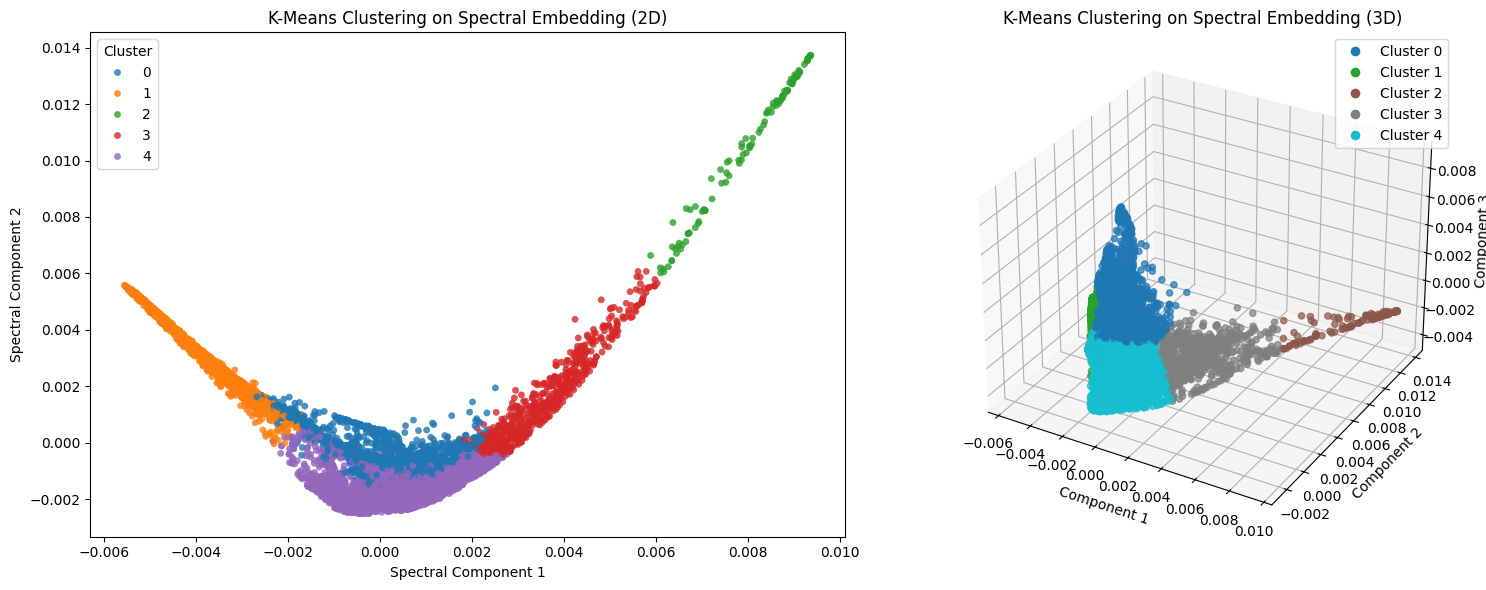

In [ ]:
fig = plt.figure(figsize=(16, 6))

# 2D scatter
ax1 = fig.add_subplot(1, 2, 1)
sns.scatterplot(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    hue=route_cluster_labels,
    palette='tab10',
    s=20,
    alpha=0.8,
    edgecolor=None,
    legend='full'
)
ax1.set_title("K-Means Clustering on Spectral Embedding (2D)")
ax1.set_xlabel("Spectral Component 1")
ax1.set_ylabel("Spectral Component 2")
ax1.legend(title="Cluster", loc='best')

# 3D scatter
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter = ax2.scatter(
    X_embedded[:, 0],
    X_embedded[:, 1],
    X_embedded[:, 2],
    c=route_cluster_labels,
    cmap='tab10',
    s=20,
    alpha=0.7
)

# Legend for clusters
legend_labels = [f"Cluster {i}" for i in np.unique(route_cluster_labels)]
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=label,
        markerfacecolor=scatter.cmap(scatter.norm(i)),
        markersize=8
    )
    for i, label in enumerate(legend_labels)
]
ax2.legend(handles=handles, loc='best')

ax2.set_title("K-Means Clustering on Spectral Embedding (3D)")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")
ax2.set_zlabel("Component 3")

plt.tight_layout()
plt.show()


#### **Analyzing Patterns in k-means Clusters**

In [ ]:
# Add cluster labels back to the original DataFrame
df_route['cluster'] = route_cluster_labels

In [ ]:
cluster_summary = df_route.groupby('cluster').agg({
    'ArrDelay': ['mean', 'std'],
    'DepDelay': ['mean', 'std'],
    'CarrierDelay': 'mean',
    'WeatherDelay': 'mean',
    'NASDelay': 'mean',
    'SecurityDelay': 'mean',
    'LateAircraftDelay': 'mean',
    'Distance': ['mean', 'std'],
    'CRSDepHour': 'mean',
    'ActiveMonths': 'mean',
    'FlightVolume': ['mean', 'count']
}).round(2)

# Flatten multi-index columns
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary.reset_index(inplace=True)

display(cluster_summary)


cluster  ArrDelay_mean  ArrDelay_std  DepDelay_mean  DepDelay_std  \
0        0          21.60         14.57          21.74         14.15   
1        1           5.09          9.33           6.99          7.23   
2        2           8.50          4.52           9.45          3.89   
3        3           9.71          4.76          10.81          4.41   
4        4           6.72          5.48           8.66          4.41   

   CarrierDelay_mean  WeatherDelay_mean  NASDelay_mean  SecurityDelay_mean  \
0               6.80               1.59           7.43                0.08   
1               4.45               0.56           2.32                0.07   
2               2.29               0.46           2.91                0.02   
3               3.32               0.79           3.05                0.02   
4               3.95               0.54           2.66                0.03   

   LateAircraftDelay_mean  Distance_mean  Distance_std  CRSDepHour_mean  \
0                    9.10         699.39        509.82            14.22   
1                    2.30         753.10        477.35            12.22   
2                    5.08         355.06        192.71            13.37   
3                    5.58         543.38        384.06            13.07   
4                    3.83        1018.37        737.21            12.65   

   ActiveMonths_mean  FlightVolume_mean  FlightVolume_count  
0              10.17             804.92                1597  
1               4.67             161.02                1090  
2              12.00            4769.15                 110  
3              12.00            2635.26                 579  
4              11.79             877.83                2832

| Cluster | Mean ArrDelay | Mean DepDelay | Top Delay Cause(s)                               | Avg Distance (mi) | Avg Dep Hour | Active Months | Avg Volume | Route Type                                        | Delay Profile                                                                                                                                       |
| ------- | ------------- | ------------- | ------------------------------------------------ | ----------------- | ------------ | ------------- | ---------- | ------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------- |
| **0**   | 21.60         | 21.74         | Late Aircraft (9.10), NAS (7.43), Carrier (6.80) | 699.4             | 14.22        | 10.17         | 804.9      | High-delay, moderate distance, moderate volume    | Routes with consistently high delays across multiple causes, dominated by late aircraft and NAS issues, suggesting systemic operational challenges. |
| **1**   | 5.09          | 6.99          | Carrier (4.45)                                   | 753.1             | 12.22        | 4.67          | 161.0      | Low-delay, low volume, seasonal                   | Seasonal, low-traffic routes with minimal delays, primarily caused by carrier-related factors.                                                      |
| **2**   | 8.50          | 9.45          | Late Aircraft (5.08)                             | 355.1             | 13.37        | 12.00         | 4769.1     | High-volume, short-haul                           | Short-haul, high-frequency routes with moderate delays, largely driven by late aircraft turnover constraints.                                       |
| **3**   | 9.71          | 10.81         | Late Aircraft (5.58), NAS (3.05)                 | 543.4             | 13.07        | 12.00         | 2635.3     | Stable, mid-distance, high volume, moderate delay | Year-round, mid-distance routes with moderate delays from late aircraft and NAS congestion, indicating predictable but persistent issues.           |
| **4**   | 6.72          | 8.66          | Carrier (3.95)                                   | 1018.4            | 12.65        | 11.79         | 877.8      | Long-haul, moderate delay                         | Primarily long-haul routes with moderate delays mostly attributed to carrier operational factors.                                                   |



#### **Analyzing Delay differences between Clusters**

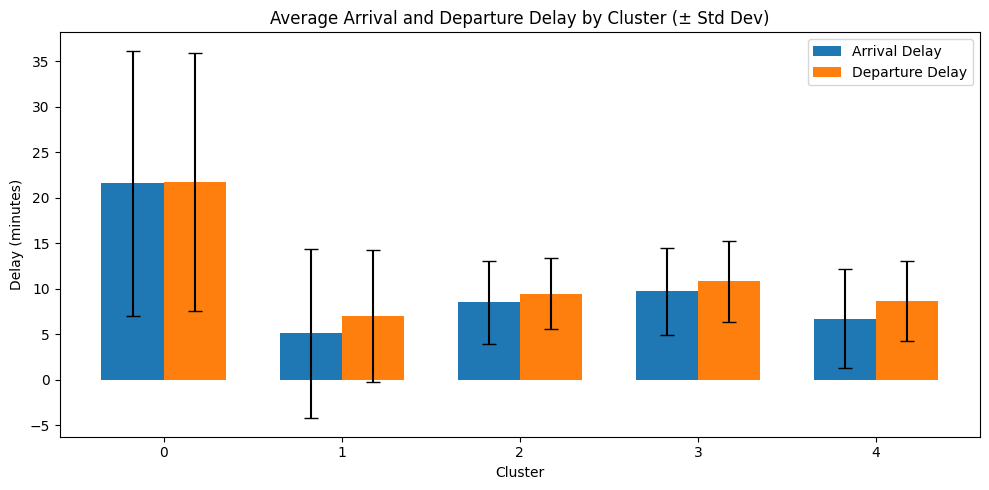

In [ ]:
# Extract values
x = np.arange(len(cluster_summary))  # cluster positions
width = 0.35

# Means
arr_means = cluster_summary['ArrDelay_mean']
dep_means = cluster_summary['DepDelay_mean']

# Standard deviations
arr_stds = cluster_summary['ArrDelay_std']
dep_stds = cluster_summary['DepDelay_std']

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x - width/2, arr_means, width, yerr=arr_stds, capsize=5, label='Arrival Delay')
ax.bar(x + width/2, dep_means, width, yerr=dep_stds, capsize=5, label='Departure Delay')

# Labels and formatting
ax.set_xticks(x)
ax.set_xticklabels(cluster_summary['cluster'].astype(str))
ax.set_xlabel('Cluster')
ax.set_ylabel('Delay (minutes)')
ax.set_title('Average Arrival and Departure Delay by Cluster (± Std Dev)')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Kruskal–Wallis for Arrival Delay
arr_groups = [df_route.loc[df_route['cluster'] == c, 'ArrDelay'] for c in sorted(df_route['cluster'].unique())]
kw_arr = stats.kruskal(*arr_groups)
print("Kruskal–Wallis for Arrival Delay:")
print(f"H-statistic = {kw_arr.statistic:.4f}, p-value = {kw_arr.pvalue:.6f}")

# Kruskal–Wallis for Departure Delay
dep_groups = [df_route.loc[df_route['cluster'] == c, 'DepDelay'] for c in sorted(df_route['cluster'].unique())]
kw_dep = stats.kruskal(*dep_groups)
print("\nKruskal–Wallis for Departure Delay:")
print(f"H-statistic = {kw_dep.statistic:.4f}, p-value = {kw_dep.pvalue:.6f}")

# Post-hoc Dunn's test with Holm correction (only if significant)
if kw_arr.pvalue < 0.05:
    print("\nDunn's Test for Arrival Delay (Holm correction):")
    dunn_arr_holm = sp.posthoc_dunn(df_route, val_col='ArrDelay', group_col='cluster', p_adjust='holm')
    print(dunn_arr_holm)

if kw_dep.pvalue < 0.05:
    print("\nDunn's Test for Departure Delay (Holm correction):")
    dunn_dep_holm = sp.posthoc_dunn(df_route, val_col='DepDelay', group_col='cluster', p_adjust='holm')
    print(dunn_dep_holm)


Kruskal–Wallis for Arrival Delay:
H-statistic = 2816.4686, p-value = 0.000000

Kruskal–Wallis for Departure Delay:
H-statistic = 2788.2190, p-value = 0.000000

Dunn's Test for Arrival Delay (Holm correction):
               0             1             2              3             4
0   1.000000e+00  0.000000e+00  2.574218e-41  1.237492e-117  0.000000e+00
1   0.000000e+00  1.000000e+00  5.385935e-03   3.445652e-24  5.286566e-03
2   2.574218e-41  5.385935e-03  1.000000e+00   7.158681e-02  7.158681e-02
3  1.237492e-117  3.445652e-24  7.158681e-02   1.000000e+00  3.557654e-19
4   0.000000e+00  5.286566e-03  7.158681e-02   3.557654e-19  1.000000e+00

Dunn's Test for Departure Delay (Holm correction):
               0             1             2              3             4
0   1.000000e+00  0.000000e+00  2.417098e-43  2.718769e-114  0.000000e+00
1   0.000000e+00  1.000000e+00  2.571503e-03   8.344677e-31  1.195739e-08
2   2.417098e-43  2.571503e-03  1.000000e+00   2.006751e-02  2.091369e-01

#### **What is the delay differences between the Clusters?**

The barplot and Dunn's Test above show that Cluster 0 has significantly higher delays than the other clusters. Cluster 0 also has a lot more variability in delay.


#### **Analyzing Flight Volume and Distance in Relation to Delay**

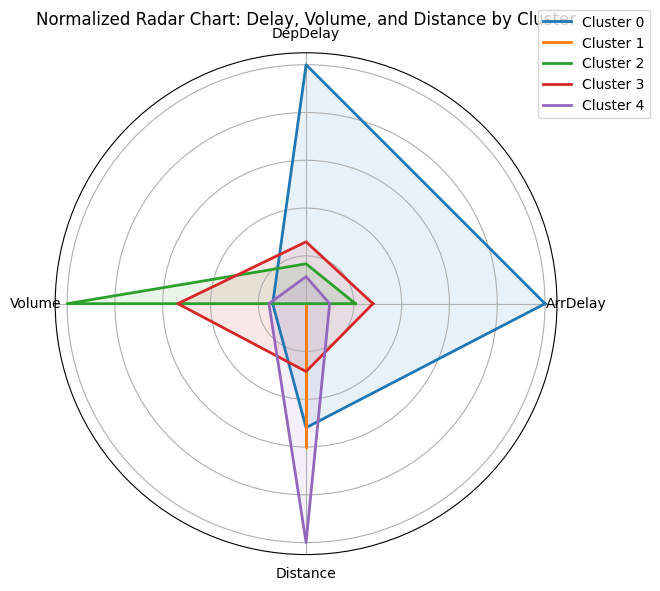

In [ ]:
# Define the features to normalize and plot
features = ['ArrDelay_mean', 'DepDelay_mean', 'FlightVolume_mean', 'Distance_mean']
angles = [n / float(len(features)) * 2 * pi for n in range(len(features))]
angles += angles[:1]  # repeat to close the circle

# Normalize the data to [0, 1] to balance the radar chart
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(cluster_summary[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)
scaled_df['cluster'] = cluster_summary['cluster'].astype(str)

# Plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

for i, row in scaled_df.iterrows():
    values = row[features].tolist() + [row[features[0]]]
    ax.plot(angles, values, label=f"Cluster {row['cluster']}", linewidth=2)
    ax.fill(angles, values, alpha=0.1)

# Configure radar chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(['ArrDelay', 'DepDelay', 'Volume', 'Distance'])
ax.set_yticklabels([])  # hide radial labels for cleaner plot
ax.set_title("Normalized Radar Chart: Delay, Volume, and Distance by Cluster", pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()



#### Sumary of Radar Chart
| Cluster | Avg Flight Volume | Avg Distance (mi) | Operational Notes |
|---------|-------------------|-------------------|-------------------|
| **0**   | 804.9             | 699.4             | Moderate volume, mid-range distance, highest delays across all clusters |
| **1**   | 161.0             | 753.1             | Low volume, moderate-long distance, lowest delays |
| **2**   | 4769.1            | 355.1             | Highest volume, short-haul distance, moderate delays |
| **3**   | 2635.3            | 543.4             | High volume, mid-range distance, moderate delays |
| **4**   | 877.8             | 1018.4            | Moderate volume, longest distance, low-to-moderate delays |




#### **How do delay levels relate to route volume and distance across clusters?**
High delays do not always coincide with high volume or long distances. Clusters with the highest delays (Cluster 0) do not necessarily have the highest volume or distance, suggesting other operational or regional factors are driving delays.

#### **Are there trade-offs between distance, volume, and delay?**
There’s no strict trade-off where higher volume or distance automatically leads to higher delays. The chart shows that some clusters (like 4) manage long distances with low delays, while others (like 0) suffer high delays without extreme distances or volumes. The data suggests that delays are more linked to cluster-specific operational factors rather than simple volume or distance.

#### **Where should operational focus be placed?**
Cluster 0 stands out as the priority, with higher delays despite having less volume and distance.

#### **Analyzing Delay Type by Cluster**

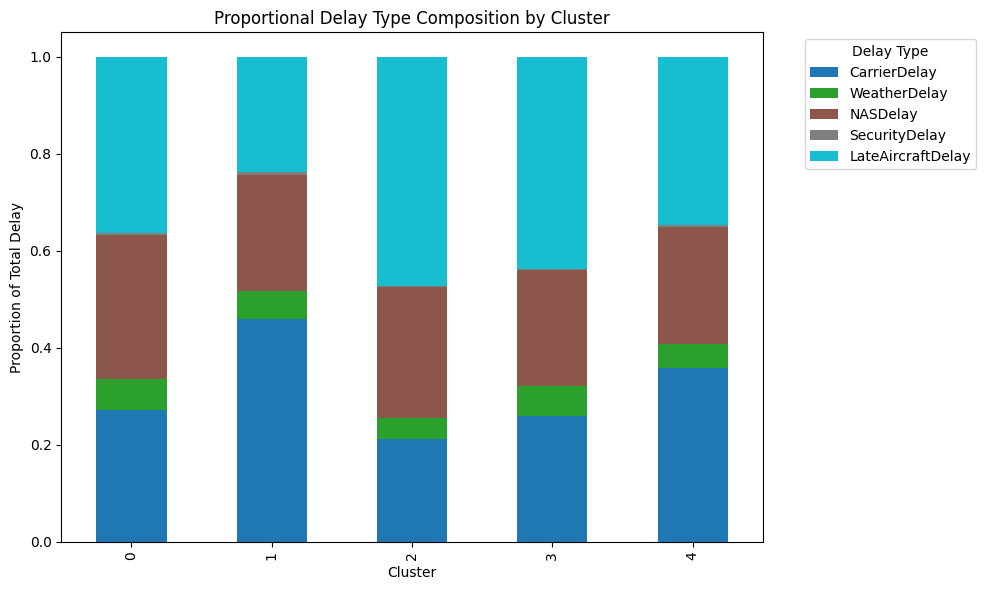

In [ ]:
# Aggregate and normalize delay types
delay_type_cols = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
delay_composition = df_route.groupby('cluster')[delay_type_cols].mean()
delay_composition_normalized = delay_composition.div(delay_composition.sum(axis=1), axis=0)

# Plot
delay_composition_normalized.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab10')
plt.title("Proportional Delay Type Composition by Cluster")
plt.ylabel("Proportion of Total Delay")
plt.xlabel("Cluster")
plt.legend(title="Delay Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Get top delay type per cluster
top_delay_type = delay_composition_normalized.idxmax(axis=1)
top_delay_share = delay_composition_normalized.max(axis=1).round(2)

# Create Markdown table
summary_df = pd.DataFrame({
    'Cluster': delay_composition_normalized.index,
    'Top_Delay_Type': top_delay_type,
    'Proportion': top_delay_share
})

# Convert to markdown text
markdown_table = summary_df.to_markdown(index=False)
print(markdown_table)


|   Cluster | Top_Delay_Type    |   Proportion |
|----------:|:------------------|-------------:|
|         0 | LateAircraftDelay |         0.36 |
|         1 | CarrierDelay      |         0.46 |
|         2 | LateAircraftDelay |         0.47 |
|         3 | LateAircraftDelay |         0.44 |
|         4 | CarrierDelay      |         0.36 |


The chart reveals that delay causes vary significantly across clusters. Operational improvements can be tailored to each cluster’s dominant delay causes.

**Cluster 0**  
- Most delay comes from **Late Aircraft Delay (~36%)**, with **NAS Delay (~36%)** nearly equal.  
- Indicates routes impacted by both downstream delays from previous flights and air traffic/congestion issues.  

**Cluster 1**  
- Dominated by **Carrier Delay (~47%)**.  
- Suggests internal airline factors like staffing, maintenance, or gate turnaround are the primary causes.  

**Cluster 2**  
- Largest share from **Late Aircraft Delay (~47%)**, with **NAS Delay (~28%)** second.  
- Carrier delays are the smallest proportion among all clusters, suggesting operational reliability but vulnerability to network disruptions.  

**Cluster 3**  
- Heavy **Late Aircraft Delay (~44%)**, followed by **NAS Delay (~25%)**, with moderate Carrier delays.  
- Likely high-frequency or tightly scheduled routes, making them vulnerable to cascading delays.  

**Cluster 4**  
- Nearly equal shares of **Carrier Delay (~36%)** and **Late Aircraft Delay (~35%)**.  
- Could reflect both airline-specific operational challenges and network-driven delays, especially on long-haul or complex routes.  


#### **Analyzing Carriers by Delay**

/tmp/ipython-input-2124607323.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  carrier_by_delay = df_route.groupby(['DelayCategory', 'UniqueCarrier']).size().unstack(fill_value=0)


UniqueCarrier    AA   CO   DL   EV   MQ   NW   OO   UA   US   WN   XE   YV
DelayCategory                                                             
High Delay      139   90   55  225  192   41  207  141  115   52  146  194
Low Delay       223  211  377  273  157  409  433  214  312  593  467  253
Moderate Delay   96   29   62    0   79   32   54   56   54  199   16   12

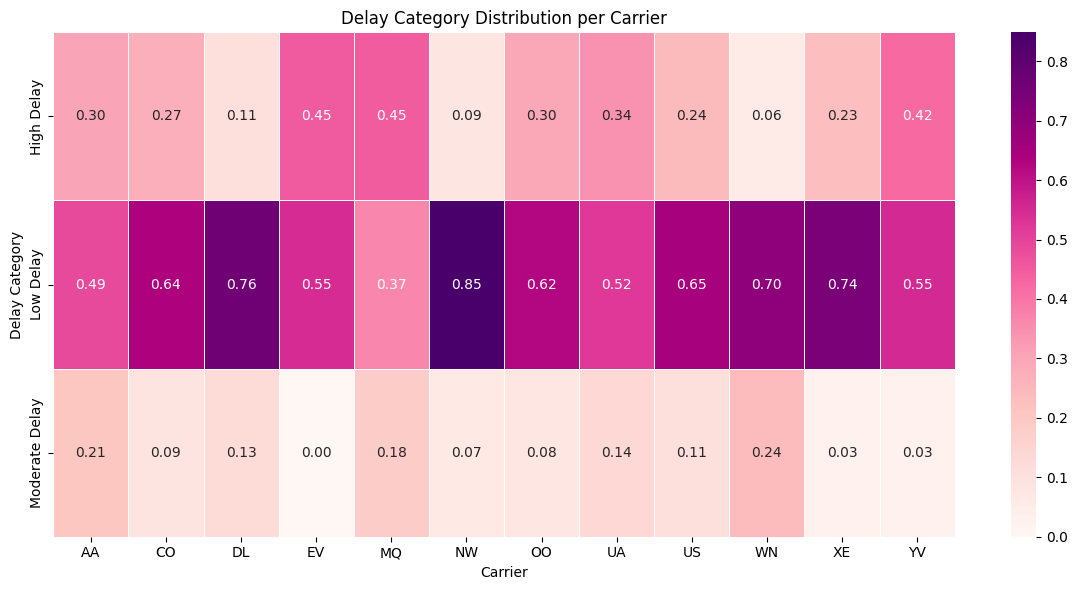

In [ ]:
# Map descriptive delay labels to clusters
delay_type_map = {
    0: 'High Delay',
    1: 'Low Delay',
    2: 'Moderate Delay',
    3: 'Moderate Delay',
    4: 'Low Delay'
}
df_route['DelayCategory'] = df_route['cluster'].map(delay_type_map)

# Count carrier presence across delay categories
carrier_by_delay = df_route.groupby(['DelayCategory', 'UniqueCarrier']).size().unstack(fill_value=0)
display(carrier_by_delay)

# Column-normalize: proportion of each delay category within each carrier
carrier_by_delay_percent = carrier_by_delay.div(carrier_by_delay.sum(axis=0), axis=1)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(carrier_by_delay_percent, annot=True, cmap='RdPu', fmt=".2f", linewidths=0.5)
plt.title("Delay Category Distribution per Carrier")
plt.xlabel("Carrier")
plt.ylabel("Delay Category")
plt.tight_layout()
plt.show()

**Carrier Delay Tendencies**  
- **NW (85%)**, **DL (76%)**, **XE (74%)**, and **US (70%)** lead in Low Delay share, showing strong reliability.  
- **EV (45%)**, **MQ (45%)**, and **YV (42%)** have the highest High Delay shares, indicating operational issues.  
- **CO (64%)** and **WN (70%)** are solid Low Delay performers but not top-ranked.  

**Carrier Spread**  
- High Delay is concentrated among regional carriers (**EV, MQ, YV, OO**), likely due to short segments, tight schedules, and weather sensitivity.    

**Strategic Implications**  
- Investigate route-level inefficiencies by focusing on high-delay routes.
- Focus improvements on high High Delay carriers (**EV, MQ, YV, OO**).  
- Benchmark top Low Delay performers (**NW, DL, XE, US**) for best practices.  
- Target regional carriers with persistent delays for audits or support programs.  


In [ ]:
# Region map
region_map = {
    'JFK': 'Northeast',
    'LAX': 'West',
    'ORD': 'Midwest',
    'ATL': 'Southeast',
    'DFW': 'South',
    'DEN': 'Mountain',
    'SEA': 'Northwest'
}

df_route['OriginRegion'] = df_route['Origin'].map(region_map)

region_dist = df_route.groupby('cluster')['OriginRegion'].value_counts(normalize=True).unstack().fillna(0).round(2)
display(region_dist)


OriginRegion  Midwest  Mountain  Northeast  Northwest  South  Southeast  West
cluster                                                                      
0                0.43      0.14       0.07       0.01   0.07       0.26  0.03
1                0.14      0.23       0.03       0.03   0.06       0.29  0.21
2                0.14      0.00       0.00       0.00   0.18       0.27  0.41
3                0.19      0.11       0.01       0.03   0.36       0.17  0.13
4                0.12      0.18       0.03       0.09   0.15       0.21  0.23

#### **Analyzing Delays by Region**

OriginRegion    Midwest  Mountain  Northeast  Northwest  South  Southeast  \
DelayCategory                                                               
High Delay         0.46      0.22       0.54       0.11   0.16       0.36   
Low Delay          0.45      0.66       0.36       0.79   0.61       0.52   
Moderate Delay     0.09      0.12       0.10       0.11   0.23       0.11   

OriginRegion    West  
DelayCategory         
High Delay      0.10  
Low Delay       0.72  
Moderate Delay  0.19

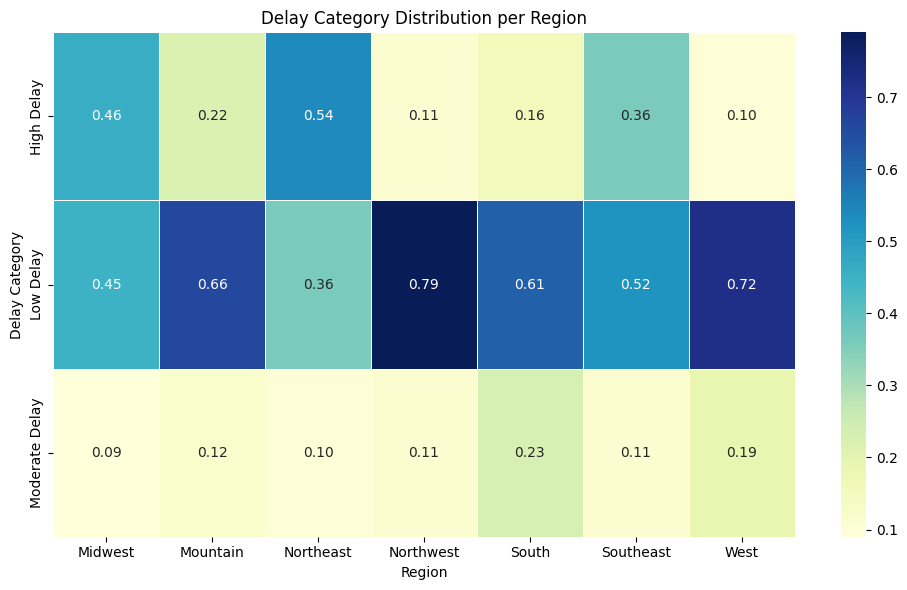

In [ ]:
region_map = {
    'JFK': 'Northeast',
    'BOS': 'Northeast',
    'PHL': 'Northeast',
    'EWR': 'Northeast',
    'LAX': 'West',
    'SFO': 'West',
    'SAN': 'West',
    'SEA': 'Northwest',
    'PDX': 'Northwest',
    'ORD': 'Midwest',
    'MSP': 'Midwest',
    'DTW': 'Midwest',
    'ATL': 'Southeast',
    'CLT': 'Southeast',
    'MIA': 'Southeast',
    'DFW': 'South',
    'IAH': 'South',
    'DEN': 'Mountain',
    'PHX': 'Mountain',
    'LAS': 'Mountain'
}

# Map origins to regions
df_route['OriginRegion'] = df_route['Origin'].map(region_map)

# Count occurrences
region_by_delay = (
    df_route.groupby(['DelayCategory', 'OriginRegion'])
    .size()
    .unstack(fill_value=0)
)

# Column-normalize: proportion of each DelayCategory within each region
region_by_delay_percent = region_by_delay.div(region_by_delay.sum(axis=0), axis=1).round(2)

display(region_by_delay_percent)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(region_by_delay_percent, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)
plt.title("Delay Category Distribution per Region")
plt.xlabel("Region")
plt.ylabel("Delay Category")
plt.tight_layout()
plt.show()


**High Delay Routes**  
- Highest proportions are in the **Northeast (54%)**, **Midwest (46%)**, and **Southeast (36%)**.  
- These regions may face greater delay risks from congestion, hub density, and adverse weather patterns.  

**Low Delay Routes**  
- Strongest performance in the **Northwest (79%)**, **West (72%)**, and **Mountain (66%)** regions.  
- The **Northeast (36%)** is notably lower, suggesting persistent challenges with congestion or weather.  

**Moderate Delay Routes**  
- Most common in the **South (23%)**, followed by the **West (19%)** and **Mountain (12%)** regions.  
- These routes see consistent but less severe delays, potentially from operational inefficiencies rather than extreme conditions.  

**Strategic Insights**  
- Delay mitigation should focus on **Northeast, Midwest, and Southeast** hubs, where High Delay shares are elevated.  
- The **Northwest** and **Mountain** regions demonstrate strong Low Delay performance, suggesting effective operations or lower traffic volumes.  
- Moderate Delay concentrations in the South may be reduced through targeted scheduling and operational adjustments.  



#### **K-means Analysis Summary**  
Spectral Embedding combined with KMeans clustering revealed five distinct U.S. flight route profiles.

Delay is not strictly tied to distance or volume. Some long-haul clusters maintain low delays, while others with moderate distances experience the highest delays.

Carrier analysis shows high-delay clusters are disproportionately served by certain regional carriers (EV, MQ, YV, OO), while top performers (NW, DL, XE, US) dominate low-delay clusters.

Regional analysis shows High Delay is concentrated in the Northeast, Midwest, and Southeast, while the Northwest, West, and Mountain regions perform best.

These findings provide a roadmap for targeting delay reduction efforts in specific regions and carriers while leveraging top performers as benchmarks for operational best practices.


### DBSCAN

The eps range was chosen based on the elbow in the distance plot, which marks the transition from dense to sparse regions. This elbow suggests a natural cutoff for DBSCAN, where points within the same cluster are tightly grouped. The range spans slightly below and above the elbow to capture both tighter and looser clusters, enabling a robust hyperparameter search that avoids overfragmentation or collapsing into a single cluster.

In [ ]:
# Spectral Embedding with fixed number of components
n_components = 3
spectral = SpectralEmbedding(n_components=n_components, affinity='nearest_neighbors', n_neighbors=30, random_state=42)
X_embedded = spectral.fit_transform(X_scaled)

Optimal eps (automatically detected): 0.000509
Optimal eps (automatically detected): 0.000459
Optimal eps (automatically detected): 0.000888
Optimal eps (automatically detected): 0.000573
Optimal eps (automatically detected): 0.000632
Optimal eps (automatically detected): 0.000651
Optimal eps (automatically detected): 0.000643
Optimal eps (automatically detected): 0.000677


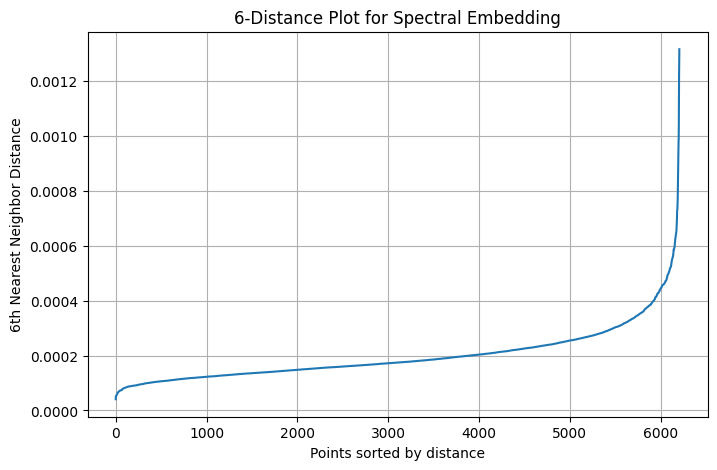

In [ ]:
# Determine the optimal epsilon (eps) parameter for DBSCAN using the k-distance plot.
# The k-distance plot helps identify a suitable eps value by looking for an 'elbow' point,
# where the distance to the k-th nearest neighbor increases sharply.

# Optimal eps with a range of k's
for k in [5, 6, 7, 8, 9, 10, 11, 12]:
  # Compute the k-nearest neighbors for each point in the embedded space (X_embedded).
  neighbors = NearestNeighbors(n_neighbors=k)
  neighbors_fit = neighbors.fit(X_embedded)
  distances, indices = neighbors_fit.kneighbors(X_embedded)

  # Get the distances to the k-th nearest neighbor for each point.
  k_distances = np.sort(distances[:, -1])

  # Automatically find the knee (elbow) point in the sorted k-distances
  kneedle = KneeLocator(
      range(len(k_distances)),        # x = sorted index positions
      k_distances,                    # y = sorted k-th neighbor distances
      curve='convex',
      direction='increasing'
  )

  # Optimal epsilon value
  optimal_eps = k_distances[kneedle.knee]
  print(f"Optimal eps (automatically detected): {optimal_eps:.6f}")


# Plot the k-distance graph for k = 6.
k = 6
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_embedded)
distances, indices = neighbors_fit.kneighbors(X_embedded)

# Get the distances to the k-th nearest neighbor for each point.
k_distances = np.sort(distances[:, -1])

# Plot the k-distance graph.
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.title(f"{k}-Distance Plot for Spectral Embedding")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}th Nearest Neighbor Distance")
plt.grid(True)
plt.show()

In [ ]:
# Parameter grid for DBSCAN
#eps_values = np.linspace(0.00035, 0.00045, 10)
eps_values = np.linspace(0.00045, 0.0007, 10)
#eps_values = np.linspace(0.0001, 0.0007, 10)
min_samples_values = [5, 6, 7, 10, 12]

# Results dictionary
dbscan_results = {}

# Grid search over eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_embedded)

        # Ignore noise points for scoring
        mask = labels != -1
        if len(set(labels[mask])) > 1 and np.sum(mask) > 1:
            sil = silhouette_score(X_embedded[mask], labels[mask])
            ch = calinski_harabasz_score(X_embedded[mask], labels[mask])
        else:
            sil, ch = float('nan'), float('nan')

        # Store results
        method_name = f"Spectral_DBSCAN_eps{eps:.7f}_min{min_samples}"
        dbscan_results[method_name] = {
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": len(set(labels)) - (1 if -1 in labels else 0),
            "silhouette": sil,
            "calinski_harabasz": ch,
            "labels": labels.tolist()
        }

        print(f"{method_name} - Clusters: {dbscan_results[method_name]['n_clusters']}, "
              f"Silhouette: {sil:.4f}, CH: {ch:.2f}")




Spectral_DBSCAN_eps0.0004500_min5 - Clusters: 6, Silhouette: -0.1863, CH: 256.80
Spectral_DBSCAN_eps0.0004500_min6 - Clusters: 6, Silhouette: -0.0751, CH: 246.59
Spectral_DBSCAN_eps0.0004500_min7 - Clusters: 5, Silhouette: -0.0151, CH: 300.43
Spectral_DBSCAN_eps0.0004500_min10 - Clusters: 5, Silhouette: 0.1868, CH: 324.60
Spectral_DBSCAN_eps0.0004500_min12 - Clusters: 5, Silhouette: 0.3149, CH: 320.52
Spectral_DBSCAN_eps0.0004778_min5 - Clusters: 4, Silhouette: 0.0268, CH: 427.89
Spectral_DBSCAN_eps0.0004778_min6 - Clusters: 4, Silhouette: 0.0269, CH: 414.27
Spectral_DBSCAN_eps0.0004778_min7 - Clusters: 6, Silhouette: -0.0418, CH: 251.65
Spectral_DBSCAN_eps0.0004778_min10 - Clusters: 5, Silhouette: 0.1885, CH: 348.07
Spectral_DBSCAN_eps0.0004778_min12 - Clusters: 4, Silhouette: 0.3900, CH: 425.83
Spectral_DBSCAN_eps0.0005056_min5 - Clusters: 3, Silhouette: 0.4603, CH: 644.84
Spectral_DBSCAN_eps0.0005056_min6 - Clusters: 3, Silhouette: 0.4612, CH: 615.26
Spectral_DBSCAN_eps0.0005056_min

In [ ]:
# Filter out invalid results
valid_results = {
    k: v for k, v in dbscan_results.items()
    if not np.isnan(v['silhouette']) and not np.isnan(v['calinski_harabasz']) and v['n_clusters'] > 1
}

# Extract arrays of scores
sil_scores = np.array([v['silhouette'] for v in valid_results.values()])
ch_scores = np.array([v['calinski_harabasz'] for v in valid_results.values()])
model_names = list(valid_results.keys())

# Normalize scores to [0, 1]
sil_norm = (sil_scores - sil_scores.min()) / (sil_scores.max() - sil_scores.min())
ch_norm = (ch_scores - ch_scores.min()) / (ch_scores.max() - ch_scores.min())

# Combined score (equal weight)
combined_scores = 0.5 * sil_norm + 0.5 * ch_norm
best_combined_index = np.argmax(combined_scores)
best_combined_name = model_names[best_combined_index]
best_combined_params = valid_results[best_combined_name]

# Highest silhouette only
best_sil_index = np.argmax(sil_scores)
best_sil_name = model_names[best_sil_index]
best_sil_params = valid_results[best_sil_name]

# Print results
print("Best DBSCAN Model (Combined Silhouette + CH Score):")
print(f"Model: {best_combined_name}")
print(f"eps = {best_combined_params['eps']}")
print(f"min_samples = {best_combined_params['min_samples']}")
print(f"Clusters = {best_combined_params['n_clusters']}")
print(f"Silhouette = {best_combined_params['silhouette']:.4f}")
print(f"CH = {best_combined_params['calinski_harabasz']:.2f}\n")

print("Best DBSCAN Model (Highest Silhouette Score):")
print(f"Model: {best_sil_name}")
print(f"eps = {best_sil_params['eps']}")
print(f"min_samples = {best_sil_params['min_samples']}")
print(f"Clusters = {best_sil_params['n_clusters']}")
print(f"Silhouette = {best_sil_params['silhouette']:.4f}")
print(f"CH = {best_sil_params['calinski_harabasz']:.2f}")

Best DBSCAN Model (Combined Silhouette + CH Score):
Model: Spectral_DBSCAN_eps0.0005611_min5
eps = 0.0005611111111111111
min_samples = 5
Clusters = 2
Silhouette = 0.6907
CH = 1267.87

Best DBSCAN Model (Highest Silhouette Score):
Model: Spectral_DBSCAN_eps0.0006444_min10
eps = 0.0006444444444444444
min_samples = 10
Clusters = 2
Silhouette = 0.6955
CH = 1237.66


In [ ]:
# Use best parameters
best_combined_params = valid_results[best_combined_name]
eps = best_combined_params['eps']
min_samples = best_combined_params['min_samples']

# Run DBSCAN with best parameters
dbscan_final = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan_final.fit_predict(X_embedded)

In [ ]:
# Filter out noise points for scoring
mask = labels != -1
X_clustered = X_embedded[mask]
labels_clustered = labels[mask]

# Compute scores
sil_final = silhouette_score(X_clustered, labels_clustered)
ch_final = calinski_harabasz_score(X_clustered, labels_clustered)
n_clusters_final = len(set(labels)) - (1 if -1 in labels else 0)

# Store with unique method name
method_name = f"DBSCAN_eps{eps:.6f}_min{min_samples}"
final_scores[method_name] = {
    "eps": eps,
    "min_samples": min_samples,
    "n_clusters": n_clusters_final,
    "silhouette": sil_final,
    "calinski_harabasz": ch_final,
    "metric": "euclidean",
    "labels": labels.tolist()
}

# Display
print(f"Final DBSCAN Model: {method_name}")
print(f"Clusters: {n_clusters_final}")
print(f"Silhouette Score: {sil_final:.4f}")
print(f"Calinski-Harabasz Index: {ch_final:.2f}")


Final DBSCAN Model: DBSCAN_eps0.000561_min5
Clusters: 2
Silhouette Score: 0.6907
Calinski-Harabasz Index: 1267.87


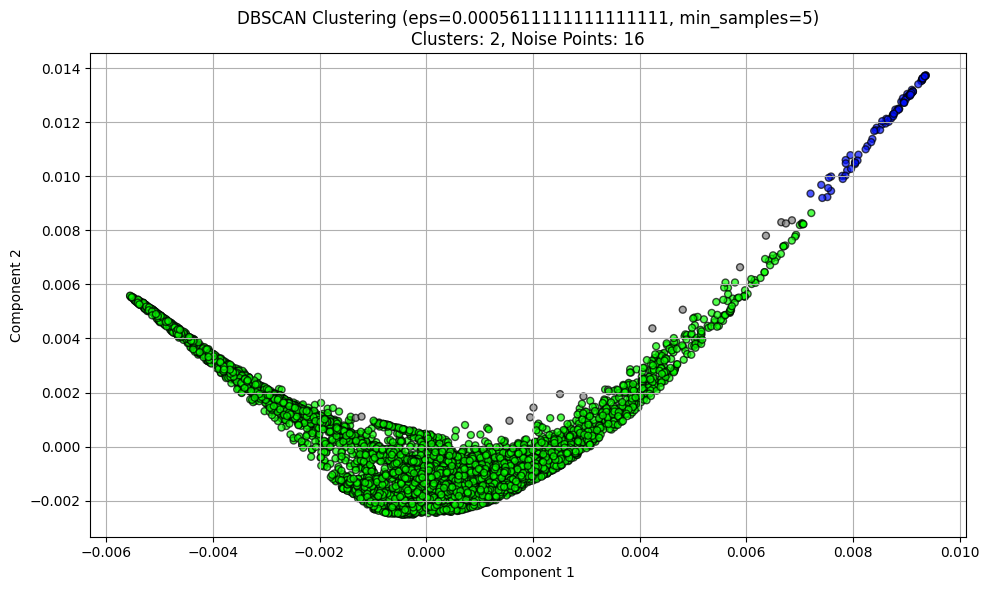

In [ ]:
# Convert labels to numpy array if not already
labels = np.array(labels)

# Number of clusters (excluding noise)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = np.sum(labels == -1)

# Plot
plt.figure(figsize=(10, 6))
palette = sns.color_palette("hsv", n_clusters)  # Adjust palette to number of clusters

# Assign colors (noise gets gray)
colors = [palette[label] if label != -1 else (0.5, 0.5, 0.5) for label in labels]

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, s=25, edgecolor='k', alpha=0.7)
plt.title(f"DBSCAN Clustering (eps={eps}, min_samples={min_samples})\n"
          f"Clusters: {n_clusters}, Noise Points: {n_noise}")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_route['DBSCAN_cluster'] = labels
cluster_summary = df_route.groupby('DBSCAN_cluster').agg({
    'ArrDelay': ['mean', 'std'],
    'DepDelay': ['mean', 'std'],
    'CarrierDelay': 'mean',
    'WeatherDelay': 'mean',
    'NASDelay': 'mean',
    'SecurityDelay': 'mean',
    'LateAircraftDelay': 'mean',
    'Distance': ['mean', 'std'],
    'CRSDepHour': 'mean',
    'ActiveMonths': 'mean',
    'FlightVolume': ['mean', 'count']
}).round(2)

# Flatten multi-index columns
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary.reset_index(inplace=True)

display(cluster_summary)


DBSCAN_cluster  ArrDelay_mean  ArrDelay_std  DepDelay_mean  DepDelay_std  \
0              -1          25.30          9.67          16.60          9.58   
1               0          10.56         11.42          11.97         10.33   
2               1           8.27          3.98           9.28          3.68   

   CarrierDelay_mean  WeatherDelay_mean  NASDelay_mean  SecurityDelay_mean  \
0               2.73               1.54          17.58                0.01   
1               4.72               0.84           3.84                0.05   
2               2.30               0.48           2.77                0.03   

   LateAircraftDelay_mean  Distance_mean  Distance_std  CRSDepHour_mean  \
0                    6.27         700.62        396.17            12.96   
1                    5.10         840.16        636.05            13.02   
2                    4.93         353.09        208.26            13.43   

   ActiveMonths_mean  FlightVolume_mean  FlightVolume_count  
0              10.12            3431.06                  16  
1              10.12             906.48                6114  
2              12.00            5131.31                  78

| Cluster | Description                       | Delay Profile                                                                           | Distance                 | Volume                                | Notes                                                   |
| ------- | --------------------------------- | --------------------------------------------------------------------------------------- | ------------------------ | ------------------------------------- | ------------------------------------------------------- |
| **1**   | Efficient, high-volume routes     | **Lowest delays** across all categories <br> ArrDelay: 8.27 min <br> DepDelay: 9.28 min | **Shortest** (353 miles) | **Highest** (5131 flights, 78 routes) | Major, consistent hub routes <br> Full-year operation   |
| **0**   | Moderate-delay, low-volume routes | Elevated **CarrierDelay** (4.72 min) <br> ArrDelay: 10.56 min <br> DepDelay: 11.97 min  | Long (840 miles)         | Moderate (906 flights, 6114 routes)   | Possibly secondary or underserved routes                |
| **-1**  | Outlier / anomalous routes        | **Extreme delays** <br> ArrDelay: 25.30 min <br> NASDelay: 17.58 min                    | Long (700 miles)         | Moderate (3431 flights, 16 routes)    | Likely irregular, weather-affected, or congested routes |


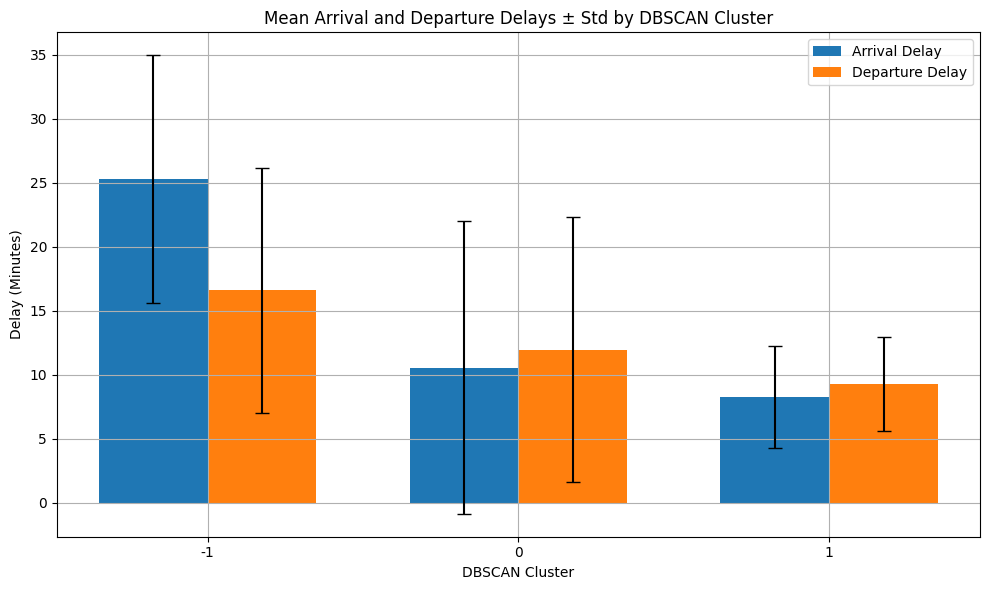

In [ ]:
# Set up x-axis labels and positions
clusters = cluster_summary['DBSCAN_cluster'].astype(str)
x = np.arange(len(clusters))
width = 0.35

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bars with error bars for Arrival Delay
arr_means = cluster_summary['ArrDelay_mean']
arr_stds = cluster_summary['ArrDelay_std']
ax.bar(x - width/2, arr_means, width, yerr=arr_stds, capsize=5, label='Arrival Delay')

# Bars with error bars for Departure Delay
dep_means = cluster_summary['DepDelay_mean']
dep_stds = cluster_summary['DepDelay_std']
ax.bar(x + width/2, dep_means, width, yerr=dep_stds, capsize=5, label='Departure Delay')

# Formatting
ax.set_xlabel('DBSCAN Cluster')
ax.set_ylabel('Delay (Minutes)')
ax.set_title('Mean Arrival and Departure Delays ± Std by DBSCAN Cluster')
ax.set_xticks(x)
ax.set_xticklabels(clusters)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

DBSCAN clustering revealed two main route groups and a small set of global outliers. Routes labeled as -1 were identified as noise points. They are routes with delay profiles that deviated significantly from the rest of the dataset.

Outliers experienced significantly higher arrival and departure delays primarily driven by NAS-related congestion and delay propagation from late aircraft.

While Clusters 0 and 1 did not differ significantly in average delays, they were distinct in terms of flight volume, route distance, and delay consistency.

Overall, DBSCAN uncovered extreme anomalies in the airline network.




In [ ]:
# Anomolies by delay types
df_route[df_route['DBSCAN_cluster'] == -1][
    ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
].mean()

CarrierDelay          2.725754
WeatherDelay          1.544944
NASDelay             17.578798
SecurityDelay         0.011486
LateAircraftDelay     6.273321
dtype: float64

In [ ]:
# Expanded region map
region_map = {
    # Northeast
    'JFK': 'Northeast', 'BOS': 'Northeast', 'PHL': 'Northeast', 'EWR': 'Northeast', 'LGA': 'Northeast', 'BUF': 'Northeast',
    # West
    'LAX': 'West', 'SFO': 'West', 'SAN': 'West', 'SMF': 'West', 'SJC': 'West', 'OAK': 'West',
    # Northwest
    'SEA': 'Northwest', 'PDX': 'Northwest', 'GEG': 'Northwest', 'BOI': 'Northwest',
    # Midwest
    'ORD': 'Midwest', 'MSP': 'Midwest', 'DTW': 'Midwest', 'STL': 'Midwest', 'MCI': 'Midwest', 'IND': 'Midwest',
    # Southeast
    'ATL': 'Southeast', 'CLT': 'Southeast', 'MIA': 'Southeast', 'FLL': 'Southeast', 'TPA': 'Southeast', 'MCO': 'Southeast', 'RDU': 'Southeast',
    # South
    'DFW': 'South', 'IAH': 'South', 'AUS': 'South', 'SAT': 'South', 'MSY': 'South', 'BNA': 'South',
    # Mountain
    'DEN': 'Mountain', 'PHX': 'Mountain', 'LAS': 'Mountain', 'SLC': 'Mountain', 'ABQ': 'Mountain',
}

# Assign with a fallback value
df_route['OriginRegion'] = df_route['Origin'].map(region_map).fillna('Other')

In [ ]:
# Identify noise points
noise_mask = (labels == -1)
noise_points = df_route.loc[noise_mask].copy()

# Add the DBSCAN label and spectral embedding coordinates for reference
noise_points['DBSCAN_Label'] = labels[noise_mask]
noise_points['Spectral_Comp1'] = X_embedded[noise_mask, 0]
noise_points['Spectral_Comp2'] = X_embedded[noise_mask, 1]

# Show the anomalies with key info
cols_to_show = [
    'Origin', 'Dest', 'UniqueCarrier', 'OriginRegion',
    'ArrDelay', 'DepDelay', 'CarrierDelay', 'WeatherDelay',
    'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
    'Spectral_Comp1', 'Spectral_Comp2'
]
display(noise_points[cols_to_show])

# Count anomalies by carrier and region and airport for summary
anomalies_by_carrier = noise_points['UniqueCarrier'].value_counts()
anomalies_by_region = noise_points['OriginRegion'].value_counts()

anomalies_by_airport = noise_points['Origin'].value_counts()
anomalies_by_airport = anomalies_by_airport[anomalies_by_airport > 0]

print("Anomalies by Carrier:")
print(anomalies_by_carrier)

print("\nAnomalies by Region:")
print(anomalies_by_region)

print("Anomalies by Origin Airport:")
print(anomalies_by_airport)

Origin Dest UniqueCarrier OriginRegion   ArrDelay   DepDelay  \
89      DFW  LGA            AA        South  23.175800  19.688939   
224     LGA  ORD            AA    Northeast  23.597854  18.897121   
259     MIA  LGA            AA    Southeast  23.648400  19.882167   
313     ORD  LGA            AA      Midwest  23.874871  20.166095   
512     CLT  EWR            CO    Southeast  31.739130  22.000000   
591     FLL  EWR            CO    Southeast  18.480604  19.475274   
636     IAH  LGA            CO        South  21.306394  21.481350   
693     MCO  EWR            CO    Southeast  20.734722  18.945739   
2424    LGA  DTW            NW    Northeast  20.672865  15.341253   
3644    ORD  DCA            UA      Midwest  12.942801  15.056980   
3664    ORD  LGA            UA      Midwest  24.404330  23.928493   
3822    BOS  PHL            US    Northeast  24.411064  19.348511   
3870    CLT  LGA            US    Southeast  20.306238  17.039382   
4091    PHL  BOS            US    Northeast  19.561781  18.278486   
5363    GPT  MSY            XE        Other  47.000000  14.000000   
5378    IAD  BUF            XE        Other  49.000000 -18.000000   

      CarrierDelay  WeatherDelay   NASDelay  SecurityDelay  LateAircraftDelay  \
89        3.008759      1.942351  17.377063       0.003667           5.035241   
224       2.665474      0.746040  12.825754       0.002214          10.905297   
259       5.216345      0.658220  15.586950       0.008236           4.277795   
313       2.971718      1.158896  15.182208       0.000171           7.800309   
512       0.130435      0.000000  27.434783       0.000000           5.913043   
591       1.010068      0.120225  18.538644       0.013918           4.410423   
636       1.931616      0.673475  20.420959       0.031676           2.399645   
693       1.497671      0.226911  17.178953       0.007125           6.349411   
2424      4.679408      0.903237   6.744146       0.008609          10.460744   
3644      3.992549      0.825553   3.236248       0.000000           9.052378   
3664      3.264378      0.695167  14.499891       0.000000           9.825935   
3822      3.628298      1.605745  10.354681       0.006809          10.556596   
3870      3.509767      0.249842  13.109011       0.058916           4.967549   
4091      6.105582      0.913443   6.771482       0.042442           8.418775   
5363      0.000000     14.000000  33.000000       0.000000           0.000000   
5378      0.000000      0.000000  49.000000       0.000000           0.000000   

      Spectral_Comp1  Spectral_Comp2  
89          0.004241        0.004374  
224         0.006658        0.008300  
259         0.001949        0.001084  
313         0.006370        0.007802  
512        -0.000969        0.000898  
591         0.002012        0.001444  
636         0.001561        0.000957  
693         0.002509        0.001943  
2424        0.003411        0.002106  
3644        0.006858        0.008371  
3664        0.004811        0.005064  
3822        0.005885        0.006635  
3870        0.002948        0.001858  
4091        0.006744        0.008256  
5363       -0.001320        0.001064  
5378       -0.001212        0.001111

Anomalies by Carrier:
UniqueCarrier
AA    4
CO    4
US    3
UA    2
XE    2
NW    1
EV    0
DL    0
OO    0
MQ    0
WN    0
YV    0
Name: count, dtype: int64

Anomalies by Region:
OriginRegion
Southeast    5
Northeast    4
Midwest      3
South        2
Other        2
Name: count, dtype: int64
Anomalies by Origin Airport:
Origin
ORD    3
CLT    2
LGA    2
MCO    1
FLL    1
IAD    1
IAH    1
MIA    1
BOS    1
PHL    1
GPT    1
DFW    1
Name: count, dtype: int64


#### **DBSCAN + Spectral Embedding Anomaly Summary**

DBSCAN with spectral embedding identified 16 noise points, routes whose delay patterns differ noticeably from the majority of routes in the dataset. These anomalies stand out in the embedded feature space because their mix of delay causes, severity levels, or operational metrics does not align with any dense cluster.

**Key Characteristics of Anomalous Routes**  
- These routes have higher delay on average.
- Some routes combine unusually high NAS delays with significant Late Aircraft delays.  
- A few show extreme single-cause delays (very high NAS or weather delays dominating total delay time).  
- Several originate from major hub airports, which may indicate unique congestion or scheduling patterns, though this cannot be confirmed from the anomaly count alone.  
- Certain anomalies display atypical delay relationships, such as low or negative departure delays paired with high arrival delays.

With only 16 anomalies detected, the sample size is too small to draw firm conclusions about specific airports, airlines, or regions. These results should be interpreted as individual cases for further operational review rather than evidence of systemic issues.

**Operational Use**  
The anomaly detection process is most valuable for flagging specific routes for follow-up investigation. Each flagged route could be examined for:  
- Persistent, route-specific delay causes  
- Rare, high-impact events (e.g., severe weather, ATC disruptions)  
- Data inconsistencies or reporting anomalies


#### Testing DBSCAN with cosine and manhattan distances.

DBSCAN with Euclidean distance is acceptable because the data was scaled and reduced to a low-dimensional space where geometric distances are interpretable. However, we tested cosine and manhattan distance metrics in DBSCAN because Euclidean distance is not always ideal for our airline route data, or after spectral embedding to see if we can extract more meaningful structure.

In [ ]:
# Define parameter grids

eps_values = np.linspace(0.0005, 0.0007, 10)
min_samples_values = [5, 6, 7, 10, 12]
distance_metrics = ['cosine', 'manhattan']

# Results dictionary
dbscan_results = {}

# Grid search over eps, min_samples, and distance metric
for metric in distance_metrics:
    for eps in eps_values:
        for min_samples in min_samples_values:
            try:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
                labels = dbscan.fit_predict(X_embedded)

                # Filter out noise
                mask = labels != -1
                if len(set(labels[mask])) > 1:
                    sil = silhouette_score(X_embedded[mask], labels[mask], metric=metric)
                    ch = calinski_harabasz_score(X_embedded[mask], labels[mask])
                else:
                    sil, ch = float('nan'), float('nan')

                # Unique key
                method_name = f"Spectral_DBSCAN_eps{eps:.7f}_min{min_samples}_metric_{metric}"
                dbscan_results[method_name] = {
                    "eps": eps,
                    "min_samples": min_samples,
                    "metric": metric,
                    "n_clusters": len(set(labels)) - (1 if -1 in labels else 0),
                    "silhouette": sil,
                    "calinski_harabasz": ch
                }

                print(f"{method_name} - Clusters: {dbscan_results[method_name]['n_clusters']}, "
                      f"Silhouette: {sil:.4f}, CH: {ch:.2f}")

            except Exception as e:
                print(f"Failed for metric={metric}, eps={eps}, min_samples={min_samples}: {e}")


Spectral_DBSCAN_eps0.0005000_min5_metric_cosine - Clusters: 112, Silhouette: -0.2861, CH: 201.08
Spectral_DBSCAN_eps0.0005000_min6_metric_cosine - Clusters: 73, Silhouette: -0.2027, CH: 291.50
Spectral_DBSCAN_eps0.0005000_min7_metric_cosine - Clusters: 46, Silhouette: -0.2921, CH: 461.82
Spectral_DBSCAN_eps0.0005000_min10_metric_cosine - Clusters: 23, Silhouette: 0.2112, CH: 904.23
Spectral_DBSCAN_eps0.0005000_min12_metric_cosine - Clusters: 19, Silhouette: 0.4004, CH: 1882.89
Spectral_DBSCAN_eps0.0005222_min5_metric_cosine - Clusters: 113, Silhouette: -0.2847, CH: 202.99
Spectral_DBSCAN_eps0.0005222_min6_metric_cosine - Clusters: 76, Silhouette: -0.1888, CH: 288.51
Spectral_DBSCAN_eps0.0005222_min7_metric_cosine - Clusters: 49, Silhouette: -0.2373, CH: 439.78
Spectral_DBSCAN_eps0.0005222_min10_metric_cosine - Clusters: 23, Silhouette: 0.0975, CH: 847.47
Spectral_DBSCAN_eps0.0005222_min12_metric_cosine - Clusters: 19, Silhouette: 0.2799, CH: 1384.61
Spectral_DBSCAN_eps0.0005444_min5_me

In [ ]:
# Filter out valid results only
valid_results = {
    k: v for k, v in dbscan_results.items()
    if not np.isnan(v['silhouette']) and not np.isnan(v['calinski_harabasz']) and v['n_clusters'] > 1
}

# Extract scores
sil_scores = np.array([v['silhouette'] for v in valid_results.values()])
ch_scores = np.array([v['calinski_harabasz'] for v in valid_results.values()])
model_names = list(valid_results.keys())

# Normalize scores to [0, 1]
sil_norm = (sil_scores - sil_scores.min()) / (sil_scores.max() - sil_scores.min())
ch_norm = (ch_scores - ch_scores.min()) / (ch_scores.max() - ch_scores.min())

# Combine scores
combined_scores = 0.5 * sil_norm + 0.5 * ch_norm
best_combined_index = np.argmax(combined_scores)
best_combined_name = model_names[best_combined_index]
best_combined_params = valid_results[best_combined_name]

# Best by silhouette only
best_sil_index = np.argmax(sil_scores)
best_sil_name = model_names[best_sil_index]
best_sil_params = valid_results[best_sil_name]

# Print combined best
print("Best DBSCAN Model (Combined Silhouette + CH Score):")
print(f"Model: {best_combined_name}")
print(f"eps = {best_combined_params['eps']}")
print(f"min_samples = {best_combined_params['min_samples']}")
print(f"metric = {best_combined_params['metric']}")
print(f"Clusters = {best_combined_params['n_clusters']}")
print(f"Silhouette Score = {best_combined_params['silhouette']:.4f}")
print(f"Calinski-Harabasz Index = {best_combined_params['calinski_harabasz']:.2f}\n")

# Print silhouette best
print("Best DBSCAN Model (Highest Silhouette Score):")
print(f"Model: {best_sil_name}")
print(f"eps = {best_sil_params['eps']}")
print(f"min_samples = {best_sil_params['min_samples']}")
print(f"metric = {best_sil_params['metric']}")
print(f"Clusters = {best_sil_params['n_clusters']}")
print(f"Silhouette Score = {best_sil_params['silhouette']:.4f}")
print(f"Calinski-Harabasz Index = {best_sil_params['calinski_harabasz']:.2f}")


Best DBSCAN Model (Combined Silhouette + CH Score):
Model: Spectral_DBSCAN_eps0.0005000_min12_metric_cosine
eps = 0.0005
min_samples = 12
metric = cosine
Clusters = 19
Silhouette Score = 0.4004
Calinski-Harabasz Index = 1882.89

Best DBSCAN Model (Highest Silhouette Score):
Model: Spectral_DBSCAN_eps0.0005000_min12_metric_cosine
eps = 0.0005
min_samples = 12
metric = cosine
Clusters = 19
Silhouette Score = 0.4004
Calinski-Harabasz Index = 1882.89


In [ ]:
# Re-run DBSCAN with best combined parameters
best_combined_params = valid_results[best_combined_name]
eps = best_combined_params['eps']
min_samples = best_combined_params['min_samples']
metric = best_combined_params['metric']

dbscan_final = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
labels = dbscan_final.fit_predict(X_embedded)

# Filter out noise
mask = labels != -1
X_clustered = X_embedded[mask]
labels_clustered = labels[mask]

# Final scoring
if len(set(labels_clustered)) > 1:
    sil_final = silhouette_score(X_clustered, labels_clustered, metric=metric)
    ch_final = calinski_harabasz_score(X_clustered, labels_clustered)
else:
    sil_final, ch_final = float('nan'), float('nan')

n_clusters_final = len(set(labels)) - (1 if -1 in labels else 0)

# Store in final_scores
method_name = f"Spectral_DBSCAN_eps{eps:.7f}_min{min_samples}_metric_{metric}"
final_scores[method_name] = {
    "eps": eps,
    "min_samples": min_samples,
    "metric": metric,
    "n_clusters": n_clusters_final,
    "silhouette": sil_final,
    "calinski_harabasz": ch_final,
    "labels": labels.tolist()
}

# Display results
print(f"Final DBSCAN Model: {method_name}")
print(f"Clusters: {n_clusters_final}")
print(f"Silhouette Score: {sil_final:.4f}")
print(f"Calinski-Harabasz Index: {ch_final:.2f}")

Final DBSCAN Model: Spectral_DBSCAN_eps0.0005000_min12_metric_cosine
Clusters: 19
Silhouette Score: 0.4004
Calinski-Harabasz Index: 1882.89


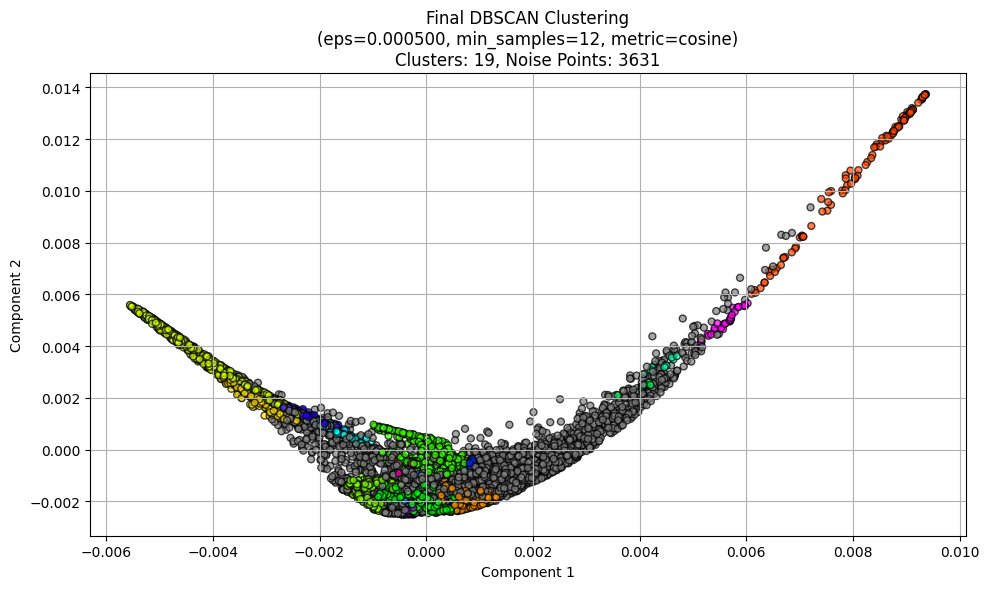

In [ ]:
# Convert labels to numpy array if not already
labels = np.array(labels)

# Number of clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = np.sum(labels == -1)

# Create a color palette
palette = sns.color_palette("hsv", n_clusters)

# Assign colors, gray for noise
colors = [palette[label] if label != -1 else (0.5, 0.5, 0.5) for label in labels]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, s=25, edgecolor='k', alpha=0.7)
plt.title(f"Final DBSCAN Clustering\n"
          f"(eps={eps:.6f}, min_samples={min_samples}, metric={metric})\n"
          f"Clusters: {n_clusters}, Noise Points: {n_noise}")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Conclusion from DBSCAN with cosine model.
This DBSCAN model (metric cosine) yields 19 small clusters and over 3,600 noise points, suggesting that the model is over-segmenting the data while treating most routes as outliers. Such fragmentation limits meaningful interpretation or statistical comparison across clusters. To improve this in future work, more effective dimensionality reduction (UMAP with tuned parameters) or alternative clustering methods (like OPTICS) should be explored to capture broader, more cohesive patterns without overwhelming noise.

### OPTICS + Spectral Embedding

OPTICS is a density-based clustering algorithm that identifies clusters of varying shapes and densities without requiring a predefined number of clusters. It naturally detects noise and outliers, making it ideal for real-world data. We used OPTICS because airline delay patterns often form irregular, non-convex clusters influenced by flight volume, route length, and operational variability. It performs especially well on graph-based embeddings like Spectral Embedding, where traditional geometric boundaries may not apply. This makes OPTICS well-suited for uncovering complex structures and anomalies in our airline delay network.

In [ ]:
# Spectral Embedding with fixed number of components
n_components = 2
spectral = SpectralEmbedding(n_components=n_components, affinity='nearest_neighbors', n_neighbors=5, random_state=42)
X_embedded = spectral.fit_transform(X_scaled)

In [ ]:
def grid_search_optics(X_embedded,
                       min_samples_list=[2, 3, 5, 8],
                       xi_list=[0.1, 0.15, 0.20],
                       metric_list=['euclidean', 'manhattan','cosine'],
                       max_clusters=200,
                       max_noise_ratio=0.8):

    param_grid = list(product(min_samples_list, xi_list, metric_list))
    results = []
    total_points = X_embedded.shape[0]

    for min_samples, xi, metric in tqdm(param_grid, desc="OPTICS Grid Search"):
        try:
            optics = OPTICS(min_samples=min_samples, xi=xi, metric=metric)
            labels = optics.fit_predict(X_embedded)

            mask = labels != -1  # Exclude noise for scoring
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = np.sum(labels == -1)
            noise_ratio = n_noise / total_points

            # Filter: too many clusters or too much noise
            if n_clusters > max_clusters or noise_ratio > max_noise_ratio:
                continue

            if n_clusters <= 1 or np.sum(mask) <= 1:
                silhouette = -1
                ch_score = -1
            else:
                silhouette = silhouette_score(X_embedded[mask], labels[mask])
                ch_score = calinski_harabasz_score(X_embedded[mask], labels[mask])

            results.append({
                'min_samples': min_samples,
                'xi': xi,
                'metric': metric,
                'clusters': n_clusters,
                'noise_points': n_noise,
                'noise_ratio': noise_ratio,
                'silhouette_score': silhouette,
                'calinski_harabasz': ch_score
            })

        except Exception as e:
            print(f"Failed for min_samples={min_samples}, xi={xi}, metric={metric}")
            continue

    return pd.DataFrame(results)

# Run
optics_grid_results = grid_search_optics(X_embedded)

OPTICS Grid Search:   0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
OPTICS Grid Search:   3%|▎         | 1/36 [00:08<04:46,  8.18s/it]/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
OPTICS Grid Search:   6%|▌         | 2/36 [00:15<04:27,  7.86s/it]/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
OPTICS Grid Search:   8%|▊         | 3/36 [00:30<05:55, 10.78s/it]/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
OPTICS Grid 

In [ ]:
# Drop invalid rows (e.g., silhouette = -1) before normalization
optics_valid = optics_grid_results[
    (optics_grid_results['silhouette_score'] > -1) &
    (optics_grid_results['calinski_harabasz'] > -1)
].copy()

# Normalize scores
sil_min, sil_max = optics_valid['silhouette_score'].min(), optics_valid['silhouette_score'].max()
ch_min, ch_max = optics_valid['calinski_harabasz'].min(), optics_valid['calinski_harabasz'].max()

optics_valid['silhouette_norm'] = (optics_valid['silhouette_score'] - sil_min) / (sil_max - sil_min + 1e-10)
optics_valid['ch_norm'] = (optics_valid['calinski_harabasz'] - ch_min) / (ch_max - ch_min + 1e-10)

# Noise penalty
total_points = X_embedded.shape[0]
optics_valid['noise_ratio'] = optics_valid['noise_points'] / total_points
optics_valid['severe_noise_penalty'] = 1 - (optics_valid['noise_ratio'] ** 2)

# Weighted score
w_sil, w_ch, w_nonnoise = 0.1, 0.1, 0.8
optics_valid['combined_score_with_noise'] = (
    w_sil * optics_valid['silhouette_norm'] +
    w_ch * optics_valid['ch_norm'] +
    w_nonnoise * optics_valid['severe_noise_penalty']
)


# Rank and display
top_by_silhouette = optics_valid.sort_values(by='silhouette_score', ascending=False).head(10)
top_combined_noise = optics_valid.sort_values(by='combined_score_with_noise', ascending=False).head(10)

print("\nTop 10 Results by Silhouette Score:")
display(top_by_silhouette[['min_samples', 'xi', 'metric', 'clusters', 'noise_points',
                           'silhouette_score', 'calinski_harabasz']])

print("\nTop 10 Results by Combined Score with Severe Noise Penalty:")
display(top_combined_noise[['min_samples', 'xi', 'metric', 'clusters', 'noise_points',
                            'silhouette_score', 'calinski_harabasz', 'combined_score_with_noise']])






Top 10 Results by Silhouette Score:


min_samples   xi     metric  clusters  noise_points  silhouette_score  \
0            8  0.1  euclidean       115          4768          0.718200   
1            8  0.1  manhattan       108          4803          0.714008   

   calinski_harabasz  
0        9485.834670  
1       13992.927015


Top 10 Results by Combined Score with Severe Noise Penalty:


min_samples   xi     metric  clusters  noise_points  silhouette_score  \
0            8  0.1  euclidean       115          4768          0.718200   
1            8  0.1  manhattan       108          4803          0.714008   

   calinski_harabasz  combined_score_with_noise  
0        9485.834670                   0.428090  
1       13992.927015                   0.421136

In [ ]:
# Select best row
best_optics_row = optics_valid.sort_values(by='combined_score_with_noise', ascending=False).iloc[0]

# Fit OPTICS model on X_embedded
optics_best = OPTICS(
    min_samples=int(best_optics_row['min_samples']),
    xi=float(best_optics_row['xi']),
    metric=best_optics_row['metric']
)
labels = optics_best.fit_predict(X_embedded)

# Compute scores
mask = labels != -1
sil_final = silhouette_score(X_embedded[mask], labels[mask])
ch_final = calinski_harabasz_score(X_embedded[mask], labels[mask])
n_clusters_final = len(set(labels)) - (1 if -1 in labels else 0)

# Store results
method_name = f"OPTICS_scaled_min{int(best_optics_row['min_samples'])}_xi{best_optics_row['xi']:.2f}_{best_optics_row['metric']}"
final_scores[method_name] = {
    "min_samples": int(best_optics_row['min_samples']),
    "xi": float(best_optics_row['xi']),
    "metric": best_optics_row['metric'],
    "n_clusters": n_clusters_final,
    "noise_points": int(np.sum(labels == -1)),
    "silhouette": sil_final,
    "calinski_harabasz": ch_final,
    "labels": labels.tolist()
}

# Display
print(f"\nFinal OPTICS Model: {method_name}")
print(f"Clusters: {n_clusters_final}")
print(f"Silhouette Score: {sil_final:.4f}")
print(f"Calinski-Harabasz Index: {ch_final:.2f}")


Final OPTICS Model: OPTICS_scaled_min8_xi0.10_euclidean
Clusters: 115
Silhouette Score: 0.7182
Calinski-Harabasz Index: 9485.83


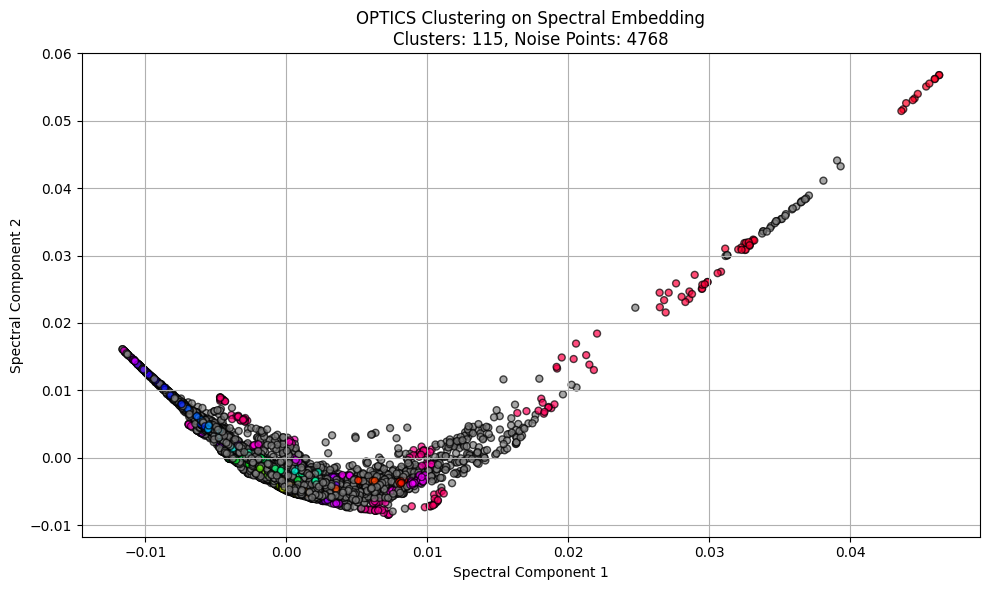

In [ ]:
# Get labels from final_scores
labels = np.array(final_scores[method_name]['labels'])

# Number of clusters and noise points
n_clusters = final_scores[method_name]['n_clusters']
n_noise = final_scores[method_name]['noise_points']

# Create color palette
palette = sns.color_palette("hsv", n_clusters)
colors = [palette[label] if label != -1 else (0.5, 0.5, 0.5) for label in labels]

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, s=25, edgecolor='k', alpha=0.7)
plt.title(f"OPTICS Clustering on Spectral Embedding\nClusters: {n_clusters}, Noise Points: {n_noise}")
plt.xlabel("Spectral Component 1")
plt.ylabel("Spectral Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

OPTICS clustering on the spectral embedding identified many clusters and the overwhelming majority of points were labeled as noise. This suggests that most of the data resides in low-density regions or flat manifolds that OPTICS does not consider dense enough to form clusters. The few clusters that were detected are small and scattered, likely located on the periphery of the embedding. This outcome indicates that the spectral embedding may have overly compressed the data structure, causing OPTICS to become overly sensitive and limiting its ability to detect meaningful cluster patterns. Adjusting n_components and n_neighbors for spectral embeddings, still resulted in an overwhelming noise. For this reason, we tried UMAP inplace of spectral.

## OPTICS + UMAP

We used UMAP with n_neighbors=10, min_dist=0.0, metric='cosine', and n_components=2 because the parameter sweep and resulting plots showed that this combination preserved important local structure while keeping clusters well separated for later analysis.

A neighbor size of 10 struck a balance between capturing fine-grained local relationships and avoiding the over-fragmentation seen with very small values, while still maintaining more detail than the overly smoothed shapes that appeared with larger values.

Setting min_dist to 0.0 allowed points within clusters to be packed tightly, making dense groupings easier to distinguish.

The cosine metric was chosen because it might preserve more meaningful structure than Euclidean distance for OPTICS.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr

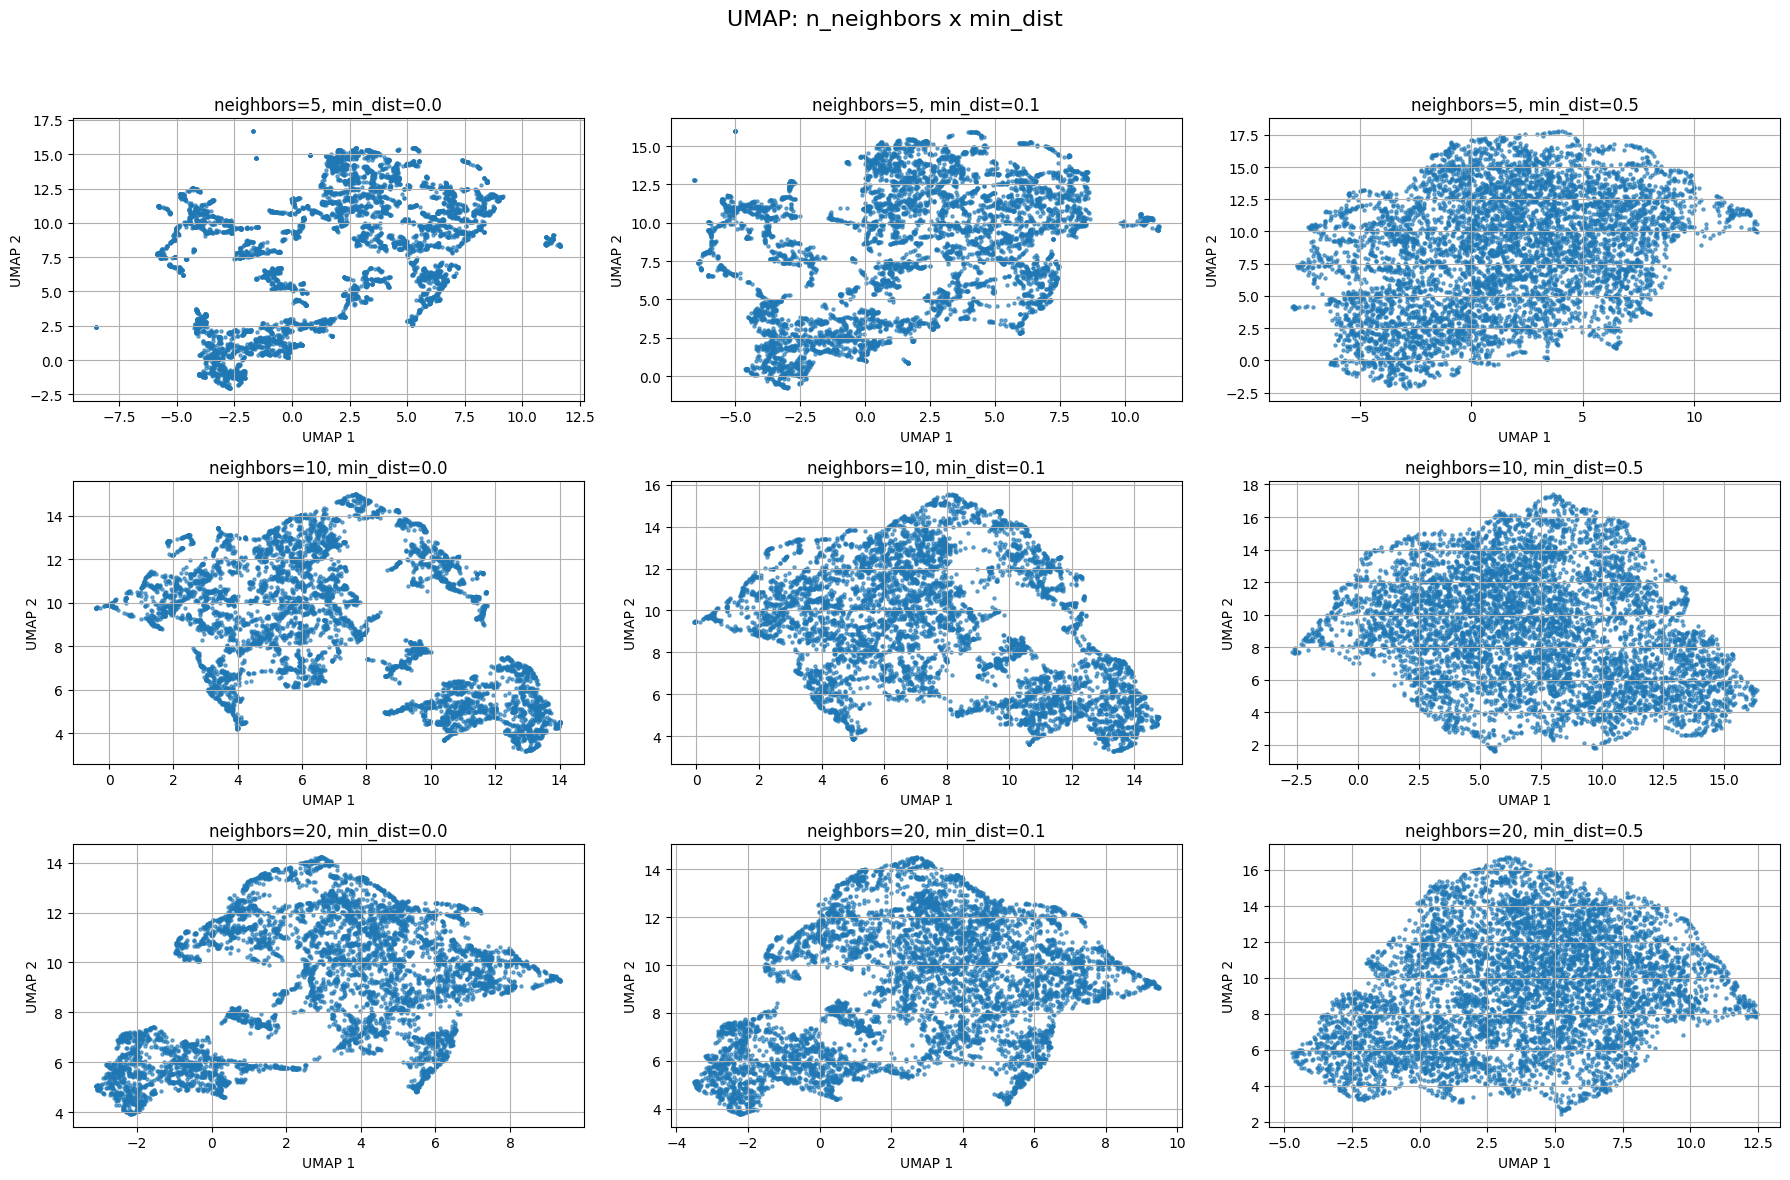

In [ ]:
# Define UMAP parameter grid
n_neighbors_list = [5, 10, 20]
min_dist_list = [0.0, 0.1, 0.5]

# Create subplot grid
fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(18, 12))
fig.suptitle("UMAP: n_neighbors x min_dist", fontsize=16)

# Loop over all parameter combinations
for i, n_neighbors in enumerate(n_neighbors_list):
    for j, min_dist in enumerate(min_dist_list):
        reducer = umap.UMAP(
            n_components=2,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            metric='euclidean',
            random_state=42
        )
        try:
            X_umap = reducer.fit_transform(X_scaled)
            ax = axes[i][j]
            ax.scatter(X_umap[:, 0], X_umap[:, 1], s=5, alpha=0.6)
            ax.set_title(f"neighbors={n_neighbors}, min_dist={min_dist}")
            ax.set_xlabel("UMAP 1")
            ax.set_ylabel("UMAP 2")
            ax.grid(True)
        except Exception as e:
            ax.set_title(f"Failed: k={n_neighbors}, d={min_dist}")
            ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr

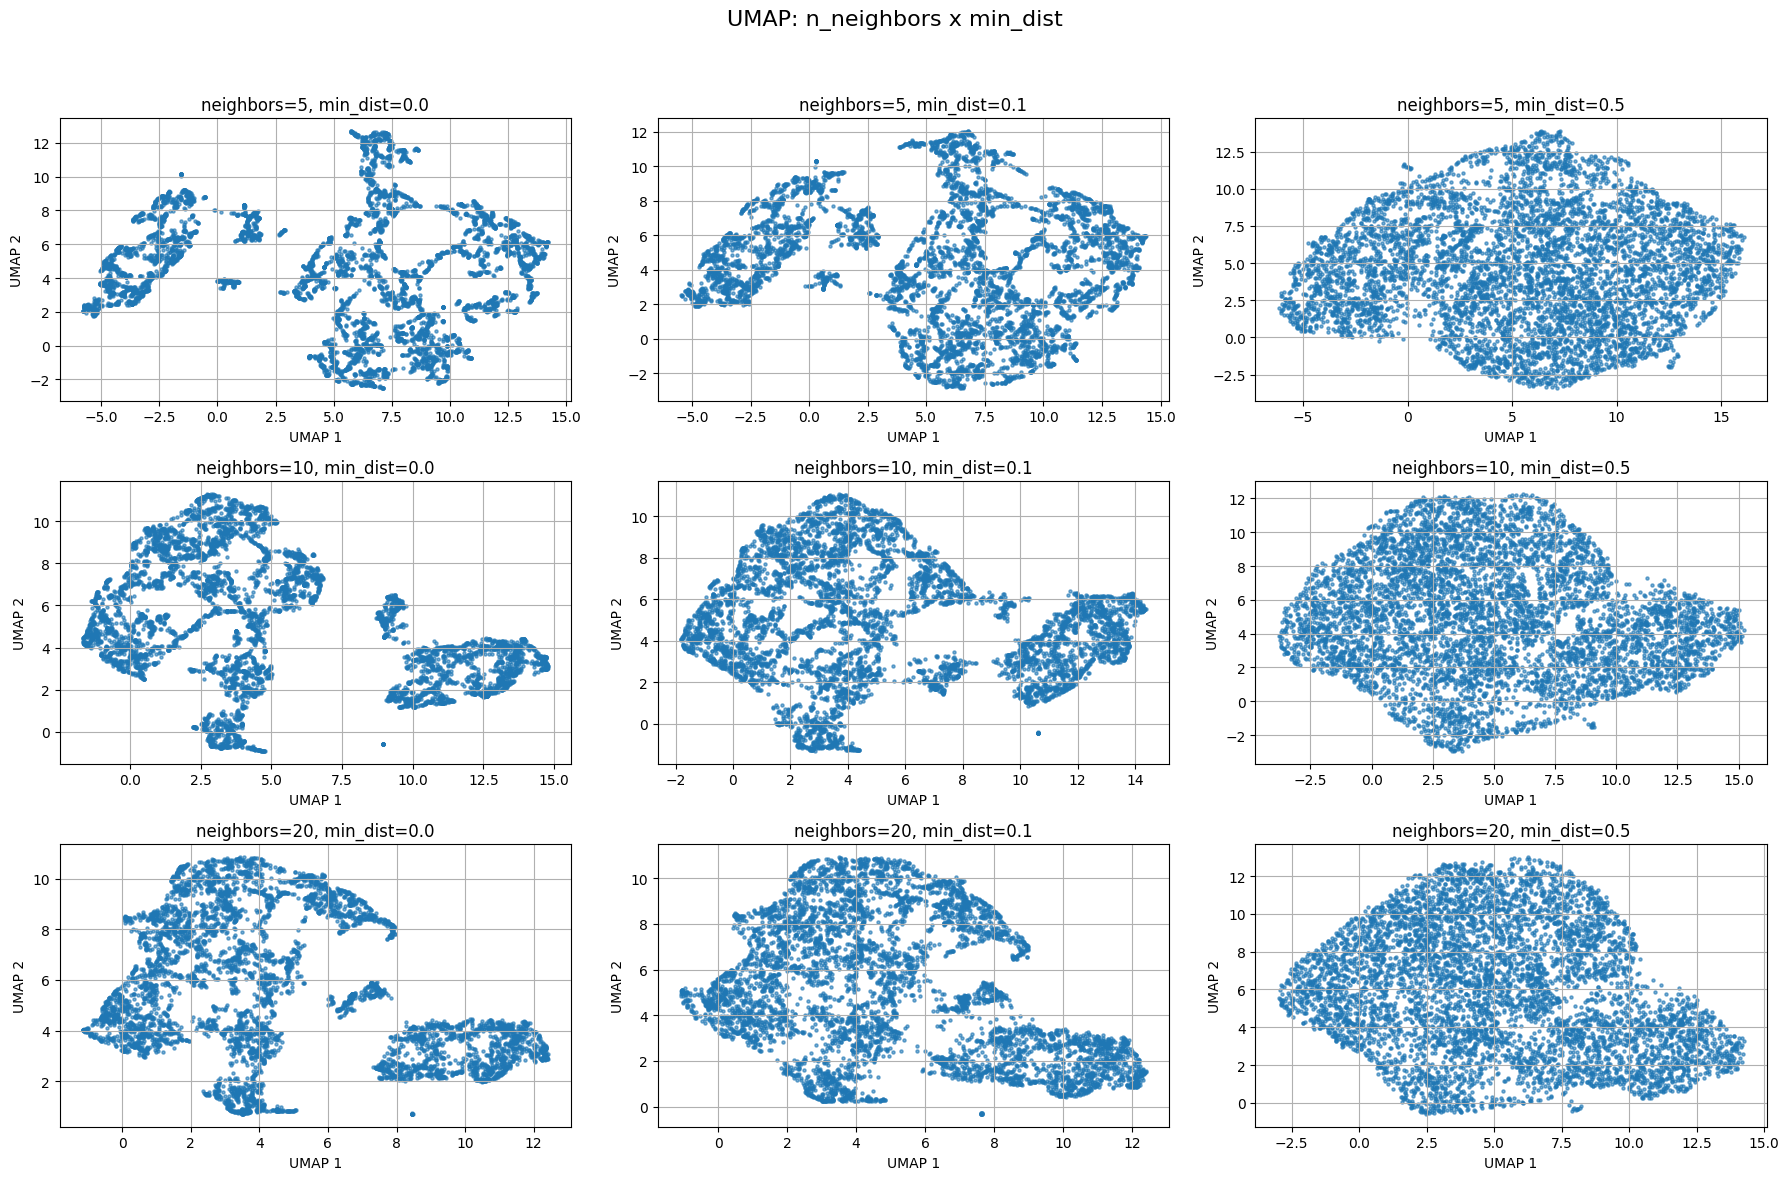

In [ ]:
# Define UMAP parameter grid
n_neighbors_list = [5, 10, 20]
min_dist_list = [0.0, 0.1, 0.5]

# Create subplot grid
fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(18, 12))
fig.suptitle("UMAP: n_neighbors x min_dist", fontsize=16)

# Loop over all parameter combinations
for i, n_neighbors in enumerate(n_neighbors_list):
    for j, min_dist in enumerate(min_dist_list):
        reducer = umap.UMAP(
            n_components=2,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            metric='cosine',
            random_state=42
        )
        try:
            X_umap = reducer.fit_transform(X_scaled)
            ax = axes[i][j]
            ax.scatter(X_umap[:, 0], X_umap[:, 1], s=5, alpha=0.6)
            ax.set_title(f"neighbors={n_neighbors}, min_dist={min_dist}")
            ax.set_xlabel("UMAP 1")
            ax.set_ylabel("UMAP 2")
            ax.grid(True)
        except Exception as e:
            ax.set_title(f"Failed: k={n_neighbors}, d={min_dist}")
            ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# UMAP with fixed parameters
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.0, metric='cosine', n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Define grid for OPTICS
min_samples_list = [8, 10, 15]
xi_list = [0.3, 0.5]
metric_list = ['euclidean', 'manhattan', 'cosine']
param_grid = list(product(min_samples_list, xi_list, metric_list))

# Run grid search
optics_results = []
total_points = X_umap.shape[0]

for min_samples, xi, metric in param_grid:
    try:
        optics = OPTICS(min_samples=min_samples, xi=xi, metric=metric)
        labels = optics.fit_predict(X_umap)
        mask = labels != -1
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)

        if n_clusters > 1 and np.sum(mask) > 1:
            sil_score = silhouette_score(X_umap[mask], labels[mask])
            ch_score = calinski_harabasz_score(X_umap[mask], labels[mask])
        else:
            sil_score = -1
            ch_score = -1

        optics_results.append({
            "min_samples": min_samples,
            "xi": xi,
            "metric": metric,
            "n_clusters": n_clusters,
            "noise_points": n_noise,
            "silhouette_score": sil_score,
            "calinski_harabasz": ch_score
        })

        print(f"OPTICS (min={min_samples}, xi={xi}, metric={metric}) -> "
              f"Clusters: {n_clusters}, Noise Points: {n_noise}, "
              f"Silhouette: {sil_score:.4f}, CH: {ch_score:.2f}")

    except Exception as e:
        print(f"Failed: min={min_samples}, xi={xi}, metric={metric} | Error: {e}")

# Convert to DataFrame
optics_df = pd.DataFrame(optics_results)


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


OPTICS (min=8, xi=0.3, metric=euclidean) -> Clusters: 57, Noise Points: 5394, Silhouette: 0.8726, CH: 90305.51
OPTICS (min=8, xi=0.3, metric=manhattan) -> Clusters: 57, Noise Points: 5380, Silhouette: 0.8599, CH: 45900.77
OPTICS (min=8, xi=0.3, metric=cosine) -> Clusters: 236, Noise Points: 2942, Silhouette: -0.3589, CH: 83.00
OPTICS (min=8, xi=0.5, metric=euclidean) -> Clusters: 19, Noise Points: 6004, Silhouette: 0.9665, CH: 126451.45
OPTICS (min=8, xi=0.5, metric=manhattan) -> Clusters: 16, Noise Points: 6039, Silhouette: 0.9739, CH: 162404.77
OPTICS (min=8, xi=0.5, metric=cosine) -> Clusters: 68, Noise Points: 5115, Silhouette: -0.1805, CH: 98.00
OPTICS (min=10, xi=0.3, metric=euclidean) -> Clusters: 32, Noise Points: 5626, Silhouette: 0.8675, CH: 29932.58
OPTICS (min=10, xi=0.3, metric=manhattan) -> Clusters: 32, Noise Points: 5651, Silhouette: 0.8911, CH: 63163.71
OPTICS (min=10, xi=0.3, metric=cosine) -> Clusters: 141, Noise Points: 3434, Silhouette: -0.2924, CH: 107.66
OPTICS (

The following parameters seem to be the only combination of parameters that yield results with reasonable noise points:

OPTICS (min=15, xi=0.5, metric=euclidean) -> Clusters: 2, Noise Points: 0, Silhouette: 0.5626, CH: 9613.23


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



OPTICS Clustering (min_samples=15, xi=0.5, metric='euclidean')
Clusters: 2, Noise Points: 0
Silhouette Score: 0.5626, Calinski-Harabasz Index: 9613.23


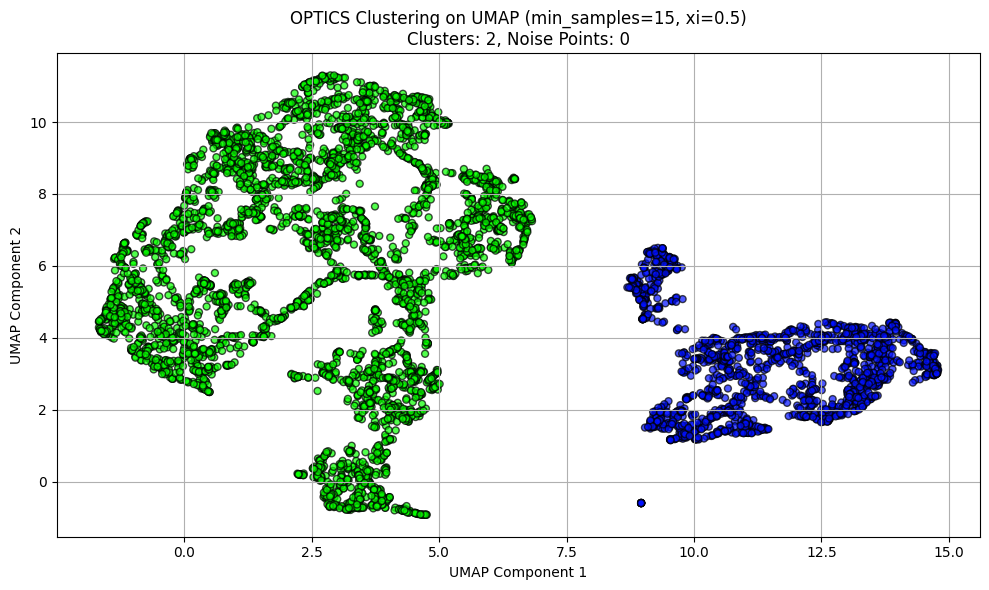

In [ ]:
# UMAP with fixed parameters
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.0, metric='cosine', n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Run OPTICS with specified parameters
optics = OPTICS(min_samples=15, xi=0.5, metric='euclidean')
labels = optics.fit_predict(X_umap)

# Score and summarize
mask = labels != -1
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = np.sum(labels == -1)

if n_clusters > 1 and np.sum(mask) > 1:
    sil_score = silhouette_score(X_umap[mask], labels[mask])
    ch_score = calinski_harabasz_score(X_umap[mask], labels[mask])
else:
    sil_score = -1
    ch_score = -1

print(f"\nOPTICS Clustering (min_samples=15, xi=0.5, metric='euclidean')")
print(f"Clusters: {n_clusters}, Noise Points: {n_noise}")
print(f"Silhouette Score: {sil_score:.4f}, Calinski-Harabasz Index: {ch_score:.2f}")

# Plot clusters
plt.figure(figsize=(10, 6))
palette = sns.color_palette("hsv", n_colors=n_clusters)
colors = [palette[label] if label != -1 else (0.5, 0.5, 0.5) for label in labels]

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, s=25, edgecolor='k', alpha=0.7)
plt.title(f"OPTICS Clustering on UMAP (min_samples=15, xi=0.5)\n"
          f"Clusters: {n_clusters}, Noise Points: {n_noise}")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


OPTICS on spectral embedding produced 115 tiny clusters and 4,768 noise points because the data lay along a narrow manifold with little separation, making it hard to form dense groups.

UMAP spread the data into two large, well-separated, high-density regions, allowing OPTICS to form clean clusters with no noise points. UMAP preserved local structure while enhancing global separation, giving OPTICS a far clearer density pattern to cluster.

The silhouette and CH scores are good and the clusters are well separated even though there are only 2 clusters.

#### **Analyzing OPTICS Clusters**

In [ ]:
# Attach OPTICS labels
df_route['OPTICS_cluster'] = labels

# relabel to consecutive ints
uniq = sorted(set(labels) - {-1})
relabel = {old:i for i, old in enumerate(uniq)}
df_route['OPTICS_cluster_clean'] = df_route['OPTICS_cluster'].map(lambda x: relabel.get(x, -1))

# Cluster summary
cluster_summary = (
    df_route[df_route['OPTICS_cluster_clean']!=-1]
      .groupby('OPTICS_cluster_clean')
      .agg({
          'ArrDelay': ['mean','std'],
          'DepDelay': ['mean','std'],
          'CarrierDelay': 'mean',
          'WeatherDelay': 'mean',
          'NASDelay': 'mean',
          'SecurityDelay': 'mean',
          'LateAircraftDelay': 'mean',
          'Distance': ['mean','std'],
          'CRSDepHour': 'mean',
          'ActiveMonths': 'mean',
          'FlightVolume': ['mean','count']
      })
      .round(2)
)

cluster_summary.columns = ['_'.join(c).strip() for c in cluster_summary.columns]
cluster_summary = cluster_summary.reset_index().rename(columns={'OPTICS_cluster_clean':'OPTICS_cluster'})
display(cluster_summary)


OPTICS_cluster  ArrDelay_mean  ArrDelay_std  DepDelay_mean  DepDelay_std  \
0               0          10.05          8.29          11.40          7.15   
1               1          11.84         16.65          13.29         15.42   

   CarrierDelay_mean  WeatherDelay_mean  NASDelay_mean  SecurityDelay_mean  \
0               3.83               0.61           4.15                0.03   
1               6.80               1.39           3.17                0.10   

   LateAircraftDelay_mean  Distance_mean  Distance_std  CRSDepHour_mean  \
0                    5.43         870.06        673.29            13.09   
1                    4.30         744.05        515.39            12.87   

   ActiveMonths_mean  FlightVolume_mean  FlightVolume_count  
0              11.81            1236.74                4416  
1               6.06             299.08                1792

#### **OPTICS + UMAP Conclusion**
The main difference between the two OPTICS + UMAP clusters is flight volume.
Cluster 0 contains high-volume, year-round routes (≈1,237 flights per route), while Cluster 1 contains low-volume, more seasonal routes (≈299 flights per route). Other factors such as delays, delay causes, or distances only show minor differences. The split is driven primarily by route activity level rather than distinct performance patterns. The only thing we can conclude with this is that flight volume does not significantly affect delay.

### Agglomerative Hierarchical Clustering

In [ ]:
# Spectral Embedding with fixed number of components
n_components = 2
# Lowering n_neighbors for more cluster separation
spectral = SpectralEmbedding(n_components=n_components, affinity='nearest_neighbors', n_neighbors=5, random_state=42)
X_embedded = spectral.fit_transform(X_scaled)

In [ ]:
def grid_search_agglomerative(X_embedded,
                               n_clusters_list=[2, 3, 4, 5, 6, 8, 10],
                               linkage_list=['ward', 'average', 'complete'],
                               affinity_list=['euclidean']):

    # Ensure compatibility: 'ward' only works with 'euclidean'
    linkage_affinity_pairs = [
        (linkage, affinity)
        for linkage, affinity in product(linkage_list, affinity_list)
        if linkage != 'ward' or affinity == 'euclidean'
    ]

    param_grid = list(product(n_clusters_list, linkage_affinity_pairs))
    results = []

    for n_clusters, (linkage, affinity) in tqdm(param_grid, desc="Agglomerative Grid Search"):
        try:
            model = AgglomerativeClustering(
                n_clusters=n_clusters,
                linkage=linkage,
                metric=affinity
            )
            labels = model.fit_predict(X_embedded)

            if len(set(labels)) <= 1:
                silhouette = -1
                ch_score = -1
            else:
                silhouette = silhouette_score(X_embedded, labels)
                ch_score = calinski_harabasz_score(X_embedded, labels)

            results.append({
                'n_clusters': n_clusters,
                'linkage': linkage,
                'affinity': affinity,
                'silhouette_score': silhouette,
                'calinski_harabasz': ch_score
            })

        except Exception as e:
            print(f"Failed for n_clusters={n_clusters}, linkage={linkage}, affinity={affinity}: {e}")
            continue

    return pd.DataFrame(results)


agglo_grid_results = grid_search_agglomerative(X_embedded)

Agglomerative Grid Search: 100%|██████████| 21/21 [00:47<00:00,  2.25s/it]


In [ ]:
# Filter valid rows
valid_agglo = agglo_grid_results[(agglo_grid_results['silhouette_score'] > -1) &
                                 (agglo_grid_results['calinski_harabasz'] > -1)].copy()

# Normalize scores
sil_min, sil_max = valid_agglo['silhouette_score'].min(), valid_agglo['silhouette_score'].max()
ch_min, ch_max = valid_agglo['calinski_harabasz'].min(), valid_agglo['calinski_harabasz'].max()

valid_agglo['silhouette_norm'] = (valid_agglo['silhouette_score'] - sil_min) / (sil_max - sil_min + 1e-10)
valid_agglo['ch_norm'] = (valid_agglo['calinski_harabasz'] - ch_min) / (ch_max - ch_min + 1e-10)

# Combine scores (equal weight)
valid_agglo['combined_score'] = 0.5 * valid_agglo['silhouette_norm'] + 0.5 * valid_agglo['ch_norm']

# Top models
top_agglo_combined = valid_agglo.sort_values(by='combined_score', ascending=False).head(10)
top_agglo_silhouette = valid_agglo.sort_values(by='silhouette_score', ascending=False).head(10)

# Display top 10
print("\n Top 10 Agglomerative Models by Combined Score:")
display(top_agglo_combined[['n_clusters', 'linkage', 'affinity', 'silhouette_score', 'calinski_harabasz', 'combined_score']])

print("\nTop 10 Agglomerative Models by Silhouette Score:")
display(top_agglo_silhouette[['n_clusters', 'linkage', 'affinity', 'silhouette_score', 'calinski_harabasz']])

# Best by combined score
best_agglo_combined = top_agglo_combined.iloc[0]
print("\nBest Agglomerative Model (Combined Score):")
print(f"n_clusters = {best_agglo_combined['n_clusters']}")
print(f"linkage = {best_agglo_combined['linkage']}")
print(f"affinity = {best_agglo_combined['affinity']}")
print(f"Silhouette Score = {best_agglo_combined['silhouette_score']:.4f}")
print(f"Calinski-Harabasz Index = {best_agglo_combined['calinski_harabasz']:.2f}")
print(f"Combined Score = {best_agglo_combined['combined_score']:.4f}")

# Best by silhouette score
best_agglo_silhouette = top_agglo_silhouette.iloc[0]
print("\nBest Agglomerative Model (Silhouette Score):")
print(f"n_clusters = {best_agglo_silhouette['n_clusters']}")
print(f"linkage = {best_agglo_silhouette['linkage']}")
print(f"affinity = {best_agglo_silhouette['affinity']}")
print(f"Silhouette Score = {best_agglo_silhouette['silhouette_score']:.4f}")
print(f"Calinski-Harabasz Index = {best_agglo_silhouette['calinski_harabasz']:.2f}")



 Top 10 Agglomerative Models by Combined Score:


n_clusters   linkage   affinity  silhouette_score  calinski_harabasz  \
0            2      ward  euclidean          0.835185        3722.223860   
1            2   average  euclidean          0.835185        3722.223860   
2            2  complete  euclidean          0.835185        3722.223860   
18          10      ward  euclidean          0.430293       13915.450541   
4            3   average  euclidean          0.820561        1975.260098   
5            3  complete  euclidean          0.820561        1975.260098   
15           8      ward  euclidean          0.455833       12692.128853   
3            3      ward  euclidean          0.585127        8101.354806   
6            4      ward  euclidean          0.564649        8646.847888   
12           6      ward  euclidean          0.469920       11163.102856   

    combined_score  
0         0.587202  
1         0.587202  
2         0.587202  
18        0.500000  
4         0.498396  
5         0.498396  
15        0.481998  
3         0.455749  
6         0.452552  
12        0.437473


Top 10 Agglomerative Models by Silhouette Score:


n_clusters   linkage   affinity  silhouette_score  calinski_harabasz
0            2      ward  euclidean          0.835185        3722.223860
1            2   average  euclidean          0.835185        3722.223860
2            2  complete  euclidean          0.835185        3722.223860
4            3   average  euclidean          0.820561        1975.260098
5            3  complete  euclidean          0.820561        1975.260098
7            4   average  euclidean          0.611088        1568.931343
3            3      ward  euclidean          0.585127        8101.354806
11           5  complete  euclidean          0.581479        6477.943458
14           6  complete  euclidean          0.580238        5305.108250
6            4      ward  euclidean          0.564649        8646.847888


Best Agglomerative Model (Combined Score):
n_clusters = 2
linkage = ward
affinity = euclidean
Silhouette Score = 0.8352
Calinski-Harabasz Index = 3722.22
Combined Score = 0.5872

Best Agglomerative Model (Silhouette Score):
n_clusters = 2
linkage = ward
affinity = euclidean
Silhouette Score = 0.8352
Calinski-Harabasz Index = 3722.22


In [ ]:
# Fit the best Agglomerative model
agglom_best = AgglomerativeClustering(
    n_clusters=int(best_agglo_combined['n_clusters']),
    linkage=best_agglo_combined['linkage'],
    metric=best_agglo_combined['affinity']
)
labels = agglom_best.fit_predict(X_embedded)

# Compute scores
sil_final = silhouette_score(X_embedded, labels)
ch_final = calinski_harabasz_score(X_embedded, labels)
n_clusters_final = len(set(labels))

# Method name
method_name = f"Agglo_{best_agglo_combined['linkage']}_n{int(best_agglo_combined['n_clusters'])}"

# Store results
final_scores[method_name] = {
    "n_clusters": n_clusters_final,
    "linkage": best_agglo_combined['linkage'],
    "metric": best_agglo_combined['affinity'],
    "silhouette": sil_final,
    "calinski_harabasz": ch_final,
    "labels": labels.tolist()
}

# Display summary
print(f"\nFinal Agglomerative Model: {method_name}")
print(f"Clusters: {n_clusters_final}")
print(f"Silhouette Score: {sil_final:.4f}")
print(f"Calinski-Harabasz Index: {ch_final:.2f}")



Final Agglomerative Model: Agglo_ward_n2
Clusters: 2
Silhouette Score: 0.8352
Calinski-Harabasz Index: 3722.22


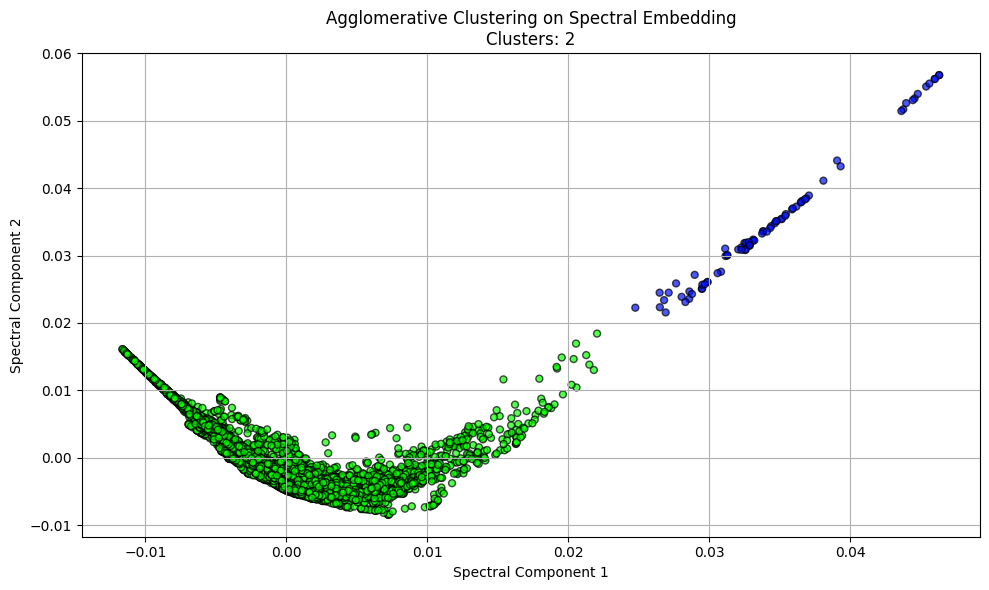

In [ ]:
# Determine number of clusters
n_clusters_final = len(set(labels))

# Create color palette
palette = sns.color_palette("hsv", n_colors=n_clusters_final)
colors = [palette[label] for label in labels]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors, s=25, edgecolor='k', alpha=0.7)
plt.title(f"Agglomerative Clustering on Spectral Embedding\nClusters: {n_clusters_final}")
plt.xlabel("Spectral Component 1")
plt.ylabel("Spectral Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


The Silhouette and CH scores are high. The data was again separated into 2 separate clusters.

In [ ]:
# Attach Agglomerative labels
df_route['AGGLO_cluster'] = labels

# ensure consecutive 0..K-1 labels
uniq = sorted(pd.unique(df_route['AGGLO_cluster']))
relabel = {old:i for i, old in enumerate(uniq)}
df_route['AGGLO_cluster_clean'] = df_route['AGGLO_cluster'].map(relabel)

# Cluster summary
agglo_summary = (
    df_route
      .groupby('AGGLO_cluster_clean', observed=True)
      .agg({
          'ArrDelay': ['mean','std'],
          'DepDelay': ['mean','std'],
          'CarrierDelay': 'mean',
          'WeatherDelay': 'mean',
          'NASDelay': 'mean',
          'SecurityDelay': 'mean',
          'LateAircraftDelay': 'mean',
          'Distance': ['mean','std'],
          'CRSDepHour': 'mean',
          'ActiveMonths': 'mean',
          'FlightVolume': ['mean','count']
      })
      .round(2)
)

# Flatten columns and display
agglo_summary.columns = ['_'.join(c).strip() for c in agglo_summary.columns]
agglo_summary = agglo_summary.reset_index().rename(columns={'AGGLO_cluster_clean':'AGGLO_cluster'})
display(agglo_summary)


AGGLO_cluster  ArrDelay_mean  ArrDelay_std  DepDelay_mean  DepDelay_std  \
0              0           10.6         11.44          11.98         10.33   
1              1            8.3          3.99           9.30          3.70   

   CarrierDelay_mean  WeatherDelay_mean  NASDelay_mean  SecurityDelay_mean  \
0               4.71               0.84           3.88                0.05   
1               2.30               0.47           2.78                0.03   

   LateAircraftDelay_mean  Distance_mean  Distance_std  CRSDepHour_mean  \
0                    5.10         839.71        635.55            13.02   
1                    4.95         353.71        209.56            13.42   

   ActiveMonths_mean  FlightVolume_mean  FlightVolume_count  
0              10.12             913.57                6131  
1              12.00            5146.40                  77

**Agglomerative Conclusion**

Cluster 0 contains shorter-distance routes (avg. ≈ 840 mi) with moderate flight volume (≈ 914 flights per route).

Cluster 1 contains very short-distance routes (avg. ≈ 354 mi) with very high flight volume (≈ 5,146 flights per route).

There is no significant difference in delay between the two clusters. Flight volume and distance does not significantly affect delays.

## Final Conclusion

**Summary of Results:**

K-means clustering with Spectral Embeddings revealed delay patterns in clusters, regions, and airlines.

DBSCAN (Euclidean distance) with Spectral Embeddings revealed route anomalies with high delay patterns. DBSCAN with cosine metric was not successful.

OPTICS with Spectral Embeddings was not successful, but with UMAP embeddings (cosine) was able to provide 2 distinct clusters which varied by volume.

Agglomerative Clustering with ward linkage and Euclidean distance yielded 2 distinct clusters which varied by volume and distance.

**Improvements and Future Work:**

There are several ways this project could be improved. From a coding perspective, we could improve the workflow by using more helper functions for model evaluation, metric comparison, and visualization.

From a modeling standpoint, distance and flight volume appear to dominate embeddings, potentially overshadowing delay metrics. Future experiments could remove or downweight these features in dimensionality reduction to see if delay-specific patterns emerge more clearly.

We did not explore temporal effects on delays, such as seasonality, monthly variations, or time-of-day impacts, which could reveal additional structure or seasonal clusters. Incorporating this would add depth to the operational insights.

Testing additional embedding techniques (e.g., UMAP with alternative distance metrics, Isomap, t-SNE) could reveal latent structures not captured by the current spectral embedding. Investing more time in tuning and experimenting with embeddings, rather than primarily focusing on clustering models, may yield better-structured feature spaces and improved clustering results.